In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import ImageEnhance
from PIL import ImageFilter
from PIL import Image
from torch.nn import Sequential, Linear, Flatten, Sigmoid, Conv2d,MaxPool2d, LeakyReLU, BatchNorm1d, AvgPool2d, LayerNorm, LazyBatchNorm2d,ZeroPad2d,AdaptiveMaxPool2d, Dropout,Threshold
import os
import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
def read_file(File ='datasets2022.npz' ):
    dataset = np.load(File)
    train_data = dataset['train']#traing data 30412
    test_data = dataset['test']    #testing data 7603
    label_train= dataset['label_train']#label for training data 30412
    return train_data, test_data, label_train


In [203]:
trainraw_data, test_data, label_train = read_file()
trainraw_data1,_,_ = read_file()

In [205]:
# don't squeeze!
trainraw_data = np.squeeze(trainraw_data)
trainraw_data1 = np.squeeze(trainraw_data1)
test_data = np.squeeze(test_data)
label_train = np.squeeze(label_train)

## Preprocessing

In [ ]:
import imutils
from PIL import ImageFilter
from PIL import Image

# 把图旋转90、180和270度
rotated_X = [imutils.rotate(x, angle=90) for x in trainraw_data]
rotated_X += [imutils.rotate(x, angle=180) for x in trainraw_data]
rotated_X += [imutils.rotate(x, angle=270) for x in trainraw_data]
rotated_X = np.expand_dims(np.array(rotated_X), axis=3) # 将 shape (n,52,52) 改回 (n,52,52,1)

# 把图上下+左右对称
flip1_X = trainraw_data[:,::-1,:,:]
flip2_X = trainraw_data[:,:,::-1,:]
trainraw_data  = np.concatenate([trainraw_data, rotated_X, flip1_X, flip2_X], axis=0)
label_train = np.concatenate([label_train]*6, axis=0)


trainraw_data = trainraw_data.squeeze()

trainraw_data = np.expand_dims(np.array(trainraw_data), axis=3)
trainraw_data, y_train = shuffle(trainraw_data, y_train, random_state=42)

del rotated_X
del flip1_X
del flip2_X


## Autoencoder

In [ ]:
epoch=15
batch_size=1024
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)
encoder = models.Model(input_tensor, latent_vector)
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))
encoded_x = encoder.predict(new_x)

In [206]:
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))
for i in range(trainraw_data1.shape[0]):
    img = Image.fromarray(trainraw_data1[i]*255)
    img = img.convert('RGB')
    img_blur=img.filter(ImageFilter.ModeFilter(3))
    img = img_blur.convert('F')
    trainraw_data1[i] = np.array(img)/255

## Train set and Validation set

In [ ]:
def five_fold_validation(X, Y, alpha, times, fold_number):
    data_size = len(Y)
    each_fold_size = data_size // fold_number
    fold = []
    accuracy = []
    for k in range(fold_number):
        fold_k = make_array(X[k*each_fold_size:(k+1)*each_fold_size,:], Y[k*each_fold_size:(k+1)*each_fold_size])
        fold.append(fold_k)
    k = 0
    for i in range(each_fold_size*fold_number, data_size):
        app = np.ones((1,4))
        app[0, 0:3] = X[i]
        app[0, 3] = Y[i]
        fold[k] = np.concatenate((fold[k],app))
        k = k + 1
    for i in range(fold_number):
        train_set = np.concatenate([fold[t] for t in list(set([0,1,2,3,4])-{i})])
        test_set = fold[i]
        beta = lg(train_set[:,0:3], train_set[:,3], alpha, times)
        Y_predict = [1 if g(beta, test_set[i,0:3]) > 0.5 else 0 for i in range(test_set.shape[0])]
        accuracy_i = 0
        for j in range(test_set.shape[0]):
            if test_set[j, 3] == Y_predict[j]:
                accuracy_i += 1
        accuracy_i = accuracy_i / test_set.shape[0]
        accuracy.append(accuracy_i)
        for i in range(test_set.shape[0]):
            print('{:<3} {:<7} {:<5}'.format(test_set[i,3], round(g(beta, test_set[i,0:3]), 4), Y_predict[i]))
    score = np.mean(np.array(accuracy))
    print("score = {}".format(score))
    return beta

In [ ]:
train_data = trainraw_data1[0:round(0.8*trainraw_data1.shape[0])].reshape((24330,1,52,52))
train_label = label_train[0:round(0.8*label_train.shape[0])]
validate_data = trainraw_data1[round(0.8*trainraw_data1.shape[0]):trainraw_data.shape[0]].reshape((6082,1,52,52))
validate_label = label_train[round(0.8*trainraw_data1.shape[0]):trainraw_data.shape[0]]

In [81]:
class Mydata(Dataset):
    def __init__(self, input_image, label):
        self.input = input_image
        self.label = label

    def __getitem__(self, idx):
        img_idx = self.input[idx]
        label_idx = self.label[idx]
        return img_idx, label_idx
    
    def __len__(self):
        return len(self.input)

In [82]:
train_set = Mydata(train_data, train_label)
validate_set = Mydata(validate_data, validate_label)
whole_set = Mydata(trainraw_data1, label_train)

In [83]:
batchsize = 32
train_dataloader = DataLoader(train_set, batch_size=batchsize, shuffle=True,drop_last=True)
validate_dataloader = DataLoader(validate_set, batch_size=batchsize, shuffle=True,drop_last=True)
whole_dataloader = DataLoader(whole_set,batch_size=batchsize,shuffle=True,drop_last=True)

## Model

### model 1: VGG net

In [179]:
def VGGLayers1(configs):
    channels = 1  # 输入通道数
    layers = []
    # 根据配置，将多个VGGBlock串联在一起组成VGGNet
    for (N, C) in configs:
        # 每个block指定N个卷积层，每层通道数是C个
        for _ in range(N):
            conv = torch.nn.Conv2d(channels, C, kernel_size=6, padding=3)
            layers += [conv, torch.nn.ReLU(inplace=True)]
            channels = C
        layers += [torch.nn.MaxPool2d(kernel_size=5, stride=2)]
        layers += [LazyBatchNorm2d()]
    return torch.nn.Sequential(*layers)
def VGGLayers2(configs):
    channels = 32  # 输入通道数
    layers = []
    # 根据配置，将多个VGGBlock串联在一起组成VGGNet
    for (N, C) in configs:
        # 每个block指定N个卷积层，每层通道数是C个
        for _ in range(N):
            conv = torch.nn.Conv2d(channels, C, kernel_size=4, padding=1)
            layers += [conv, torch.nn.ReLU(inplace=True)]
            channels = C
        layers += [torch.nn.MaxPool2d(kernel_size=3, stride=2)]
    return torch.nn.Sequential(*layers)
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # batch*1*28*28（每次会送入batch个样本，输入通道数1（黑白图像），图像分辨率是28x28）
        # 下面的卷积层Conv2d的第一个参数指输入通道数，第二个参数指输出通道数，第三个参数指卷积核的大小
        self.VGG1 = VGGLayers1(configs=[(2,32)])
        self.VGG2 = VGGLayers2(configs=[(2,32),(2,3)])
        # 下面的全连接层Linear的第一个参数指输入通道数，第二个参数指输出通道数
        self.fc1 = torch.nn.Linear(20000, 300)
        self.fc2 = torch.nn.Linear(300, 200)
        self.fc3 = torch.nn.Linear(300, 8)
        self.droupout = torch.nn.Dropout(p=0.5)
        self.fla = Flatten()
        self.sig = Sigmoid()
    def forward(self, x):
        out = self.VGG1(x)
#         out = self.VGG2(out)
        out = self.fla(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.droupout(out)
#         out = self.fc2(out)
#         out = F.relu(out)
        out = self.droupout(out)
        out = self.fc3(out)
        out = self.sig(out)  
        return out


In [21]:
train_loss = []
test_loss = []
cnn_net = Net()
loss = nn.L1Loss()
# loss = loss.cuda()
optim = torch.optim.SGD(cnn_net.parameters(),lr=0.01,momentum=0.9,nesterov=True,)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[50,100,150], gamma=0.3)
# cnn_net = cnn_net.cuda()
for epoch in range(200):
    cnn_net.train()
    print("--------第{}轮训练开始---------".format(epoch))
    total_tloss = 0
    for data in train_dataloader:
        img, label = data
        img = img.to(torch.float32)
        label = label.to(torch.float32)
        outputs = cnn_net(img)
        outputs = outputs.squeeze()
        optim.zero_grad()
        l1loss = loss(outputs,label)
        accuracy = 0
        total_step = 0
#         if epoch == 30:
#             for i in range(outputs.shape[0]):
#                 jud = 1
#                 for j in range(outputs.shape[1]):
#                     if outputs[i][j] >= 0.5:
#                         if label[i][j] != 1:
#                             jud = 0
#                     else:
#                         if label[i][j] != 0:
#                             jud = 0
#                 accuracy += jud
#                 total_step += 1
#             accuracy_rate = 100*accuracy/total_step
#             print(accuracy_rate)
        l1loss.backward()
        optim.step()
        total_tloss += l1loss
    train_loss.append(total_tloss)
    with torch.no_grad():
        cnn_net.eval()
        accuracy = 0
        total_step = 0
        total_loss = 0
        for data in validate_dataloader:
            img, label = data
            img = img.to(torch.float32)
            label = label.to(torch.float32)
            outputs = cnn_net(img)
#             for i in range(outputs.shape[0]):
#                 if outputs[i] >=0.5:
#                     if label[i] == 1:
#                         accuracy += 1
#                 else:
#                     if label[i] == 0:
#                         accuracy+=1
#                 total_step +=1
#             outputs = outputs.squeeze()
            for i in range(outputs.shape[0]):
                for j in range(outputs.shape[1]):
                    if outputs[i][j] >= 0.5:
                        outputs[i][j] = 1
                    else:
                        outputs[i][j] = 0
            for i in range(outputs.shape[0]):
                jud = 1
                for j in range(outputs.shape[1]):
                    if outputs[i][j] != label[i][j]:
                        jud = 0
                accuracy += jud
                total_step += 1
            l1loss = loss(outputs,label)
            total_loss += l1loss            
            accuracy_rate = 100*accuracy/total_step
            print("准确率为：{}%".format(accuracy_rate))
        print('totalloss = {}'.format(total_loss))
        test_loss.append(total_loss)

--------第0轮训练开始---------
准确率为：78.125%
准确率为：67.1875%
准确率为：60.416666666666664%
准确率为：58.59375%
准确率为：58.125%
准确率为：56.770833333333336%
准确率为：55.357142857142854%
准确率为：56.25%
准确率为：55.55555555555556%
准确率为：56.875%
准确率为：57.67045454545455%
准确率为：57.552083333333336%
准确率为：55.52884615384615%
准确率为：56.25%
准确率为：57.083333333333336%
准确率为：57.6171875%
准确率为：57.904411764705884%
准确率为：57.291666666666664%
准确率为：57.07236842105263%
准确率为：56.5625%
准确率为：56.54761904761905%
准确率为：56.67613636363637%
准确率为：56.52173913043478%
准确率为：56.901041666666664%
准确率为：56.875%
准确率为：57.09134615384615%
准确率为：57.407407407407405%
准确率为：57.36607142857143%
准确率为：57.2198275862069%
准确率为：57.083333333333336%
准确率为：57.15725806451613%
准确率为：57.12890625%
准确率为：57.196969696969695%
准确率为：57.07720588235294%
准确率为：57.05357142857143%
准确率为：56.770833333333336%
准确率为：56.6722972972973%
准确率为：56.82565789473684%
准确率为：56.65064102564103%
准确率为：56.5625%
准确率为：56.40243902439025%
准确率为：56.62202380952381%
准确率为：56.68604651162791%
准确率为：56.60511363636363%
准确率为：56.666666666666664%
准确率为

准确率为：57.32248520710059%
准确率为：57.37132352941177%
准确率为：57.30994152046784%
准确率为：57.26744186046512%
准确率为：57.225433526011564%
准确率为：57.18390804597701%
准确率为：57.17857142857143%
准确率为：57.15553977272727%
准确率为：57.1680790960452%
准确率为：57.250702247191015%
准确率为：57.24511173184357%
准确率为：57.25694444444444%
准确率为：57.216850828729285%
准确率为：57.1771978021978%
准确率为：57.17213114754098%
准确率为：57.15013586956522%
准确率为：57.12837837837838%
准确率为：57.14045698924731%
准确率为：57.1524064171123%
准确率为：57.180851063829785%
准确率为：57.12632275132275%
准确率为：57.05592105263158%
totalloss = 11.38671875
--------第2轮训练开始---------
准确率为：56.25%
准确率为：57.8125%
准确率为：56.25%
准确率为：54.6875%
准确率为：55.0%
准确率为：54.6875%
准确率为：54.910714285714285%
准确率为：56.640625%
准确率为：57.986111111111114%
准确率为：58.125%
准确率为：57.67045454545455%
准确率为：58.072916666666664%
准确率为：58.65384615384615%
准确率为：58.25892857142857%
准确率为：58.75%
准确率为：59.375%
准确率为：59.19117647058823%
准确率为：59.201388888888886%
准确率为：59.046052631578945%
准确率为：59.53125%
准确率为：59.523809523809526%
准确率为：59.09090909090909%
准确率为：5

准确率为：59.830729166666664%
准确率为：59.827586206896555%
准确率为：59.803082191780824%
准确率为：59.82142857142857%
准确率为：59.7972972972973%
准确率为：59.77348993288591%
准确率为：59.770833333333336%
准确率为：59.7682119205298%
准确率为：59.765625%
准确率为：59.76307189542484%
准确率为：59.80113636363637%
准确率为：59.83870967741935%
准确率为：59.875801282051285%
准确率为：59.952229299363054%
准确率为：59.988132911392405%
准确率为：60.02358490566038%
准确率为：60.05859375%
准确率为：60.09316770186335%
准确率为：60.088734567901234%
准确率为：60.10352760736196%
准确率为：60.0609756097561%
准确率为：60.05681818181818%
准确率为：60.033885542168676%
准确率为：60.12350299401198%
准确率为：60.06324404761905%
准确率为：60.04068047337278%
准确率为：60.05514705882353%
准确率为：60.051169590643276%
准确率为：60.08357558139535%
准确率为：60.00722543352601%
准确率为：59.91379310344828%
准确率为：59.964285714285715%
准确率为：59.88991477272727%
准确率为：59.93997175141243%
准确率为：59.95435393258427%
准确率为：60.00349162011173%
准确率为：59.91319444444444%
准确率为：59.8756906077348%
准确率为：59.87293956043956%
准确率为：59.87021857923497%
准确率为：59.952445652173914%
准确率为：59.89864864864864

准确率为：60.989583333333336%
准确率为：60.97623966942149%
准确率为：60.9375%
准确率为：60.823170731707314%
准确率为：60.81149193548387%
准确率为：60.8%
准确率为：60.739087301587304%
准确率为：60.826771653543304%
准确率为：60.8154296875%
准确率为：60.85271317829457%
准确率为：60.91346153846154%
准确率为：61.04484732824427%
准确率为：60.890151515151516%
准确率为：60.94924812030075%
准确率为：60.82089552238806%
准确率为：60.78703703703704%
准确率为：60.7077205882353%
准确率为：60.675182481751825%
准确率为：60.59782608695652%
准确率为：60.6339928057554%
准确率为：60.691964285714285%
准确率为：60.54964539007092%
准确率为：60.585387323943664%
准确率为：60.57692307692308%
准确率为：60.525173611111114%
准确率为：60.560344827586206%
准确率为：60.61643835616438%
准确率为：60.62925170068027%
准确率为：60.620777027027025%
准确率为：60.633389261744966%
准确率为：60.604166666666664%
准确率为：60.63741721854305%
准确率为：60.64967105263158%
准确率为：60.68218954248366%
准确率为：60.65340909090909%
准确率为：60.66532258064516%
准确率为：60.69711538461539%
准确率为：60.728503184713375%
准确率为：60.75949367088607%
准确率为：60.750786163522015%
准确率为：60.76171875%
准确率为：60.81133540372671%
准确率为：60.8796

准确率为：92.31004901960785%
准确率为：92.2633495145631%
准确率为：92.24759615384616%
准确率为：92.23214285714286%
准确率为：92.1875%
准确率为：92.17289719626169%
准确率为：92.10069444444444%
准确率为：92.00114678899082%
准确率为：91.93181818181819%
准确率为：92.00450450450451%
准确率为：92.02008928571429%
准确率为：92.03539823008849%
准确率为：92.07785087719299%
准确率为：92.03804347826087%
准确率为：92.07974137931035%
准确率为：92.1207264957265%
准确率为：92.10805084745763%
准确率为：92.1218487394958%
准确率为：92.05729166666667%
准确率为：92.07128099173553%
准确率为：92.00819672131148%
准确率为：92.07317073170732%
准确率为：92.01108870967742%
准确率为：91.975%
准确率为：91.9890873015873%
准确率为：92.05216535433071%
准确率为：92.0166015625%
准确率为：92.07848837209302%
准确率为：92.09134615384616%
准确率为：92.08015267175573%
准确率为：92.09280303030303%
准确率为：92.10526315789474%
准确率为：92.04757462686567%
准确率为：92.03703703703704%
准确率为：91.93474264705883%
准确率为：91.90237226277372%
准确率为：91.87047101449275%
准确率为：91.81654676258992%
准确率为：91.83035714285714%
准确率为：91.86613475177305%
准确率为：91.90140845070422%
准确率为：91.91433566433567%
准确率为：91.9053819444444

准确率为：91.50735294117646%
准确率为：91.53343023255815%
准确率为：91.63074712643679%
准确率为：91.6903409090909%
准确率为：91.6432584269663%
准确率为：91.63194444444444%
准确率为：91.5521978021978%
准确率为：91.54211956521739%
准确率为：91.4986559139785%
准确率为：91.52260638297872%
准确率为：91.54605263157895%
准确率为：91.6015625%
准确率为：91.59149484536083%
准确率为：91.54974489795919%
准确率为：91.54040404040404%
准确率为：91.5625%
准确率为：91.52227722772277%
准确率为：91.4828431372549%
准确率为：91.56553398058253%
准确率为：91.61658653846153%
准确率为：91.60714285714286%
准确率为：91.62735849056604%
准确率为：91.67640186915888%
准确率为：91.63773148148148%
准确率为：91.65711009174312%
准确率为：91.5909090909091%
准确率为：91.61036036036036%
准确率为：91.51785714285714%
准确率为：91.56526548672566%
准确率为：91.5844298245614%
准确率为：91.60326086956522%
准确率为：91.48706896551724%
准确率为：91.50641025641026%
准确率为：91.44597457627118%
准确率为：91.36029411764706%
准确率为：91.328125%
准确率为：91.34814049586777%
准确率为：91.3422131147541%
准确率为：91.3109756097561%
准确率为：91.35584677419355%
准确率为：91.4%
准确率为：91.44345238095238%
准确率为：91.46161417322834%
准确率为：91.40625%


准确率为：88.4375%
准确率为：88.38028169014085%
准确率为：88.28125%
准确率为：88.27054794520548%
准确率为：88.30236486486487%
准确率为：88.41666666666667%
准确率为：88.28125%
准确率为：88.35227272727273%
准确率为：88.26121794871794%
准确率为：88.37025316455696%
准确率为：88.1640625%
准确率为：88.11728395061728%
准确率为：88.03353658536585%
准确率为：88.02710843373494%
准确率为：87.90922619047619%
准确率为：87.86764705882354%
准确率为：87.89970930232558%
准确率为：87.82327586206897%
准确率为：87.74857954545455%
准确率为：87.78089887640449%
准确率为：87.74305555555556%
准确率为：87.77472527472527%
准确率为：87.90760869565217%
准确率为：88.00403225806451%
准确率为：87.99867021276596%
准确率为：88.02631578947368%
准确率为：87.98828125%
准确率为：87.95103092783505%
准确率为：88.0420918367347%
准确率为：87.9419191919192%
准确率为：87.96875%
准确率为：87.96410891089108%
准确率为：87.89828431372548%
准确率为：87.86407766990291%
准确率为：87.890625%
准确率为：87.82738095238095%
准确率为：87.88325471698113%
准确率为：87.79205607476635%
准确率为：87.84722222222223%
准确率为：87.8440366972477%
准确率为：87.89772727272727%
准确率为：87.80968468468468%
准确率为：87.75111607142857%
准确率为：87.85951327433628%
准确率为：

准确率为：92.21813725490196%
准确率为：92.24759615384616%
准确率为：92.21698113207547%
准确率为：92.30324074074075%
准确率为：92.32954545454545%
准确率为：92.41071428571429%
准确率为：92.4890350877193%
准确率为：92.5646551724138%
准确率为：92.53177966101696%
准确率为：92.60416666666667%
准确率为：92.67418032786885%
准确率为：92.54032258064517%
准确率为：92.60912698412699%
准确率为：92.529296875%
准确率为：92.54807692307692%
准确率为：92.56628787878788%
准确率为：92.5839552238806%
准确率为：92.5091911764706%
准确率为：92.57246376811594%
准确率为：92.54464285714286%
准确率为：92.56161971830986%
准确率为：92.66493055555556%
准确率为：92.67979452054794%
准确率为：92.60979729729729%
准确率为：92.625%
准确率为：92.63980263157895%
准确率为：92.65422077922078%
准确率为：92.66826923076923%
准确率为：92.60284810126582%
准确率为：92.4609375%
准确率为：92.51543209876543%
准确率为：92.4923780487805%
准确率为：92.50753012048193%
准确率为：92.55952380952381%
准确率为：92.53676470588235%
准确率为：92.62354651162791%
准确率为：92.60057471264368%
准确率为：92.61363636363636%
准确率为：92.66151685393258%
准确率为：92.70833333333333%
准确率为：92.71978021978022%
准确率为：92.73097826086956%
准确率为：92.708333333333

准确率为：91.5625%
准确率为：91.43145161290323%
准确率为：91.11328125%
准确率为：91.09848484848484%
准确率为：90.99264705882354%
准确率为：90.98214285714286%
准确率为：90.79861111111111%
准确率为：90.87837837837837%
准确率为：91.11842105263158%
准确率为：91.18589743589743%
准确率为：91.015625%
准确率为：91.08231707317073%
准确率为：91.14583333333333%
准确率为：91.27906976744185%
准确率为：91.26420454545455%
准确率为：91.38888888888889%
准确率为：91.44021739130434%
准确率为：91.3563829787234%
准确率为：91.27604166666667%
准确率为：91.39030612244898%
准确率为：91.4375%
准确率为：91.54411764705883%
准确率为：91.40625%
准确率为：91.50943396226415%
准确率为：91.55092592592592%
准确率为：91.5909090909091%
准确率为：91.57366071428571%
准确率为：91.61184210526316%
准确率为：91.43318965517241%
准确率为：91.26059322033899%
准确率为：91.25%
准确率为：91.29098360655738%
准确率为：91.22983870967742%
准确率为：91.26984126984127%
准确率为：91.30859375%
准确率为：91.34615384615384%
准确率为：91.33522727272727%
准确率为：91.37126865671642%
准确率为：91.40625%
准确率为：91.48550724637681%
准确率为：91.51785714285714%
准确率为：91.50528169014085%
准确率为：91.62326388888889%
准确率为：91.48116438356165%
准确率为：91.55405405

准确率为：87.5%
准确率为：87.5%
准确率为：87.5%
准确率为：87.5%
准确率为：87.29166666666667%
准确率为：87.5%
准确率为：87.31617647058823%
准确率为：87.15277777777777%
准确率为：87.82894736842105%
准确率为：87.8125%
准确率为：88.0952380952381%
准确率为：88.06818181818181%
准确率为：87.36413043478261%
准确率为：86.97916666666667%
准确率为：87.0%
准确率为：87.01923076923077%
准确率为：86.45833333333333%
准确率为：86.49553571428571%
准确率为：86.85344827586206%
准确率为：86.5625%
准确率为：86.39112903225806%
准确率为：86.328125%
准确率为：86.07954545454545%
准确率为：86.02941176470588%
准确率为：86.33928571428571%
准确率为：86.45833333333333%
准确率为：86.73986486486487%
准确率为：87.00657894736842%
准确率为：86.93910256410257%
准确率为：87.109375%
准确率为：87.34756097560975%
准确率为：87.27678571428571%
准确率为：87.42732558139535%
准确率为：87.2159090909091%
准确率为：87.15277777777777%
准确率为：87.22826086956522%
准确率为：87.16755319148936%
准确率为：87.04427083333333%
准确率为：87.11734693877551%
准确率为：87.0625%
准确率为：87.07107843137256%
准确率为：87.19951923076923%
准确率为：87.20518867924528%
准确率为：87.32638888888889%
准确率为：87.38636363636364%
准确率为：87.44419642857143%
准确率为：87.5%
准确率为：87.446

准确率为：93.20436507936508%
准确率为：93.1907894736842%
totalloss = 1.828125
--------第19轮训练开始---------
准确率为：84.375%
准确率为：84.375%
准确率为：88.54166666666667%
准确率为：89.0625%
准确率为：91.25%
准确率为：92.1875%
准确率为：91.96428571428571%
准确率为：92.1875%
准确率为：92.36111111111111%
准确率为：92.5%
准确率为：92.32954545454545%
准确率为：92.1875%
准确率为：92.78846153846153%
准确率为：93.08035714285714%
准确率为：93.125%
准确率为：93.359375%
准确率为：93.56617647058823%
准确率为：93.75%
准确率为：93.42105263157895%
准确率为：93.59375%
准确率为：93.30357142857143%
准确率为：93.4659090909091%
准确率为：93.34239130434783%
准确率为：93.48958333333333%
准确率为：93.25%
准确率为：93.14903846153847%
准确率为：93.28703703703704%
准确率为：93.52678571428571%
准确率为：93.53448275862068%
准确率为：93.4375%
准确率为：93.54838709677419%
准确率为：93.5546875%
准确率为：93.56060606060606%
准确率为：93.56617647058823%
准确率为：93.48214285714286%
准确率为：93.57638888888889%
准确率为：93.66554054054055%
准确率为：93.75%
准确率为：93.50961538461539%
准确率为：93.671875%
准确率为：93.52134146341463%
准确率为：93.52678571428571%
准确率为：93.45930232558139%
准确率为：93.60795454545455%
准确率为：93.47222222222223%
准确率

准确率为：92.875%
准确率为：92.89772727272727%
准确率为：92.90254237288136%
准确率为：92.88974719101124%
准确率为：92.85963687150839%
准确率为：92.84722222222223%
准确率为：92.86947513812154%
准确率为：92.90865384615384%
准确率为：92.91325136612022%
准确率为：92.91779891304348%
准确率为：92.95608108108108%
准确率为：92.94354838709677%
准确率为：92.9812834224599%
准确率为：92.96875%
准确率为：92.98941798941799%
准确率为：92.99342105263158%
totalloss = 1.87890625
--------第21轮训练开始---------
准确率为：93.75%
准确率为：95.3125%
准确率为：95.83333333333333%
准确率为：94.53125%
准确率为：94.375%
准确率为：94.79166666666667%
准确率为：94.64285714285714%
准确率为：94.53125%
准确率为：94.44444444444444%
准确率为：93.75%
准确率为：92.89772727272727%
准确率为：93.22916666666667%
准确率为：93.02884615384616%
准确率为：93.30357142857143%
准确率为：93.33333333333333%
准确率为：93.75%
准确率为：93.56617647058823%
准确率为：93.22916666666667%
准确率为：93.09210526315789%
准确率为：92.5%
准确率为：92.11309523809524%
准确率为：92.1875%
准确率为：92.3913043478261%
准确率为：92.31770833333333%
准确率为：92.125%
准确率为：91.94711538461539%
准确率为：91.89814814814815%
准确率为：91.96428571428571%
准确率为：92.24137931034483%
准确

准确率为：92.71496815286625%
准确率为：92.6621835443038%
准确率为：92.66902515723271%
准确率为：92.63671875%
准确率为：92.62422360248448%
准确率为：92.66975308641975%
准确率为：92.67638036809817%
准确率为：92.6638719512195%
准确率为：92.70833333333333%
准确率为：92.73343373493977%
准确率为：92.73952095808383%
准确率为：92.72693452380952%
准确率为：92.71449704142012%
准确率为：92.73897058823529%
准确率为：92.7266081871345%
准确率为：92.75072674418605%
准确率为：92.72037572254335%
准确率为：92.69037356321839%
准确率为：92.71428571428571%
准确率为：92.73792613636364%
准确率为：92.77895480225989%
准确率为：92.74929775280899%
准确率为：92.73743016759776%
准确率为：92.70833333333333%
准确率为：92.73135359116021%
准确率为：92.71978021978022%
准确率为：92.69125683060109%
准确率为：92.66304347826087%
准确率为：92.63513513513513%
准确率为：92.65793010752688%
准确率为：92.6470588235294%
准确率为：92.66954787234043%
准确率为：92.65873015873017%
准确率为：92.66447368421052%
totalloss = 2.02734375
--------第23轮训练开始---------
准确率为：93.75%
准确率为：96.875%
准确率为：96.875%
准确率为：97.65625%
准确率为：96.875%
准确率为：95.83333333333333%
准确率为：95.08928571428571%
准确率为：95.3125%
准确率为：95.138888888

准确率为：92.49543795620438%
准确率为：92.48188405797102%
准确率为：92.46852517985612%
准确率为：92.5%
准确率为：92.50886524822695%
准确率为：92.45158450704226%
准确率为：92.46066433566433%
准确率为：92.49131944444444%
准确率为：92.52155172413794%
准确率为：92.50856164383562%
准确率为：92.453231292517%
准确率为：92.48310810810811%
准确率为：92.53355704697987%
准确率为：92.47916666666667%
准确率为：92.46688741721854%
准确率为：92.49588815789474%
准确率为：92.52450980392157%
准确率为：92.53246753246754%
准确率为：92.54032258064517%
准确率为：92.58814102564102%
准确率为：92.59554140127389%
准确率为：92.62262658227849%
准确率为：92.61006289308176%
准确率为：92.59765625%
准确率为：92.64363354037268%
准确率为：92.63117283950618%
准确率为：92.59969325153374%
准确率为：92.62576219512195%
准确率为：92.65151515151516%
准确率为：92.62048192771084%
准确率为：92.60853293413173%
准确率为：92.578125%
准确率为：92.60355029585799%
准确率为：92.62867647058823%
准确率为：92.61695906432749%
准确率为：92.64171511627907%
准确率为：92.59393063583815%
准确率为：92.60057471264368%
准确率为：92.60714285714286%
准确率为：92.61363636363636%
准确率为：92.62005649717514%
准确率为：92.59129213483146%
准确率为：92.6152234636871

准确率为：92.45233050847457%
准确率为：92.48949579831933%
准确率为：92.47395833333333%
准确率为：92.48450413223141%
准确率为：92.52049180327869%
准确率为：92.5558943089431%
准确率为：92.54032258064517%
准确率为：92.575%
准确率为：92.60912698412699%
准确率为：92.59350393700787%
准确率为：92.6025390625%
准确率为：92.61143410852713%
准确率为：92.64423076923077%
准确率为：92.58110687022901%
准确率为：92.61363636363636%
准确率为：92.64567669172932%
准确率为：92.67723880597015%
准确率为：92.68518518518519%
准确率为：92.69301470588235%
准确率为：92.7007299270073%
准确率为：92.73097826086956%
准确率为：92.73830935251799%
准确率为：92.74553571428571%
准确率为：92.73049645390071%
准确率为：92.73767605633803%
准确率为：92.78846153846153%
准确率为：92.79513888888889%
准确率为：92.82327586206897%
准确率为：92.82962328767124%
准确率为：92.81462585034014%
准确率为：92.8420608108108%
准确率为：92.82718120805369%
准确率为：92.85416666666667%
准确率为：92.86009933774834%
准确率为：92.8248355263158%
准确率为：92.85130718954248%
准确率为：92.89772727272727%
准确率为：92.88306451612904%
准确率为：92.8886217948718%
准确率为：92.89410828025478%
准确率为：92.85996835443038%
准确率为：92.84591194968553%
准确率为：92.8320

准确率为：92.54331683168317%
准确率为：92.49387254901961%
准确率为：92.47572815533981%
准确率为：92.51802884615384%
准确率为：92.55952380952381%
准确率为：92.54127358490567%
准确率为：92.5233644859813%
准确率为：92.41898148148148%
准确率为：92.4598623853211%
准确率为：92.4715909090909%
准确率为：92.48310810810811%
准确率为：92.46651785714286%
准确率为：92.47787610619469%
准确率为：92.51644736842105%
准确率为：92.55434782608695%
准确率为：92.5646551724138%
准确率为：92.60149572649573%
准确率为：92.5052966101695%
准确率为：92.48949579831933%
准确率为：92.47395833333333%
准确率为：92.45867768595042%
准确率为：92.49487704918033%
准确率为：92.5558943089431%
准确率为：92.56552419354838%
准确率为：92.5%
准确率为：92.48511904761905%
准确率为：92.44586614173228%
准确率为：92.3828125%
准确率为：92.36918604651163%
准确率为：92.42788461538461%
准确率为：92.4618320610687%
准确率为：92.4715909090909%
准确率为：92.4812030075188%
准确率为：92.53731343283582%
准确率为：92.5%
准确率为：92.53216911764706%
准确率为：92.51824817518248%
准确率为：92.52717391304348%
准确率为：92.53597122302158%
准确率为：92.56696428571429%
准确率为：92.55319148936171%
准确率为：92.4955985915493%
准确率为：92.52622377622377%
准确率为：92.491

准确率为：93.96067415730337%
准确率为：93.95833333333333%
准确率为：93.99038461538461%
准确率为：94.02173913043478%
准确率为：93.98521505376344%
准确率为：94.01595744680851%
准确率为：94.01315789473684%
准确率为：94.07552083333333%
准确率为：94.10438144329896%
准确率为：94.10076530612245%
准确率为：94.16035353535354%
准确率为：94.0625%
准确率为：93.99752475247524%
准确率为：93.9031862745098%
准确率为：93.9623786407767%
准确率为：93.93028846153847%
准确率为：93.95833333333333%
准确率为：93.92688679245283%
准确率为：93.89602803738318%
准确率为：93.80787037037037%
准确率为：93.77866972477064%
准确率为：93.75%
准确率为：93.75%
准确率为：93.77790178571429%
准确率为：93.80530973451327%
准确率为：93.8048245614035%
准确率为：93.80434782608695%
准确率为：93.80387931034483%
准确率为：93.8301282051282%
准确率为：93.80296610169492%
准确率为：93.80252100840336%
准确率为：93.828125%
准确率为：93.85330578512396%
准确率为：93.82684426229508%
准确率为：93.8770325203252%
准确率为：93.87600806451613%
准确率为：93.9%
准确率为：93.9484126984127%
准确率为：93.92224409448819%
准确率为：93.9453125%
准确率为：93.9437984496124%
准确率为：93.89423076923077%
准确率为：93.89312977099236%
准确率为：93.93939393939394%
准确率为：93.89097

准确率为：92.7854938271605%
准确率为：92.83536585365853%
准确率为：92.80873493975903%
准确率为：92.81994047619048%
准确率为：92.75735294117646%
准确率为：92.80523255813954%
准确率为：92.78017241379311%
准确率为：92.79119318181819%
准确率为：92.7317415730337%
准确率为：92.74305555555556%
准确率为：92.75412087912088%
准确率为：92.73097826086956%
准确率为：92.74193548387096%
准确率为：92.75265957446808%
准确率为：92.59868421052632%
准确率为：92.64322916666667%
准确率为：92.6868556701031%
准确率为：92.7295918367347%
准确率为：92.70833333333333%
准确率为：92.65625%
准确率为：92.6980198019802%
准确率为：92.6470588235294%
准确率为：92.65776699029126%
准确率为：92.66826923076923%
准确率为：92.70833333333333%
准确率为：92.77712264150944%
准确率为：92.75700934579439%
准确率为：92.76620370370371%
准确率为：92.68922018348624%
准确率为：92.67045454545455%
准确率为：92.70833333333333%
准确率为：92.68973214285714%
准确率为：92.75442477876106%
准确率为：92.76315789473684%
准确率为：92.77173913043478%
准确率为：92.78017241379311%
准确率为：92.78846153846153%
准确率为：92.84957627118644%
准确率为：92.77836134453781%
准确率为：92.83854166666667%
准确率为：92.84607438016529%
准确率为：92.85348360655738%
准确率为：92

准确率为：93.11440677966101%
准确率为：93.125%
准确率为：93.13524590163935%
准确率为：93.14516129032258%
准确率为：93.10515873015873%
准确率为：93.1640625%
准确率为：93.17307692307692%
准确率为：93.1344696969697%
准确率为：93.14365671641791%
准确率为：93.10661764705883%
准确率为：93.02536231884058%
准确率为：93.125%
准确率为：93.08978873239437%
准确率为：93.05555555555556%
准确率为：93.0222602739726%
准确率为：93.07432432432432%
准确率为：93.08333333333333%
准确率为：93.09210526315789%
准确率为：93.18181818181819%
准确率为：93.18910256410257%
准确率为：93.19620253164557%
准确率为：93.125%
准确率为：93.13271604938272%
准确率为：93.17835365853658%
准确率为：93.22289156626506%
准确率为：93.22916666666667%
准确率为：93.2720588235294%
准确率为：93.31395348837209%
准确率为：93.35488505747126%
准确率为：93.39488636363636%
准确率为：93.36376404494382%
准确率为：93.29861111111111%
准确率为：93.37225274725274%
准确率为：93.27445652173913%
准确率为：93.21236559139786%
准确率为：93.18484042553192%
准确率为：93.125%
准确率为：93.09895833333333%
准确率为：93.1701030927835%
准确率为：93.17602040816327%
准确率为：93.21338383838383%
准确率为：93.25%
准确率为：93.2549504950495%
准确率为：93.25980392156863%
准确率为：93.2645

准确率为：93.26923076923077%
准确率为：93.28125%
准确率为：93.21646341463415%
准确率为：93.22916666666667%
准确率为：93.09593023255815%
准确率为：93.18181818181819%
准确率为：93.05555555555556%
准确率为：93.07065217391305%
准确率为：93.0186170212766%
准确率为：92.83854166666667%
准确率为：92.92091836734694%
准确率为：93.0%
准确率为：92.8921568627451%
准确率为：92.90865384615384%
准确率为：92.98349056603773%
准确率为：92.99768518518519%
准确率为：93.06818181818181%
准确率为：93.02455357142857%
准确率为：93.1469298245614%
准确率为：93.21120689655173%
准确率为：93.22033898305085%
准确率为：93.33333333333333%
准确率为：93.34016393442623%
准确率为：93.29637096774194%
准确率为：93.20436507936508%
准确率为：93.1640625%
准确率为：93.125%
准确率为：93.08712121212122%
准确率为：93.09701492537313%
准确率为：92.96875%
准确率为：93.07065217391305%
准确率为：93.03571428571429%
准确率为：93.08978873239437%
准确率为：93.14236111111111%
准确率为：93.10787671232876%
准确率为：93.20101351351352%
准确率为：93.16666666666667%
准确率为：93.17434210526316%
准确率为：93.14123376623377%
准确率为：93.10897435897436%
准确率为：92.99841772151899%
准确率为：93.0078125%
准确率为：93.01697530864197%
准确率为：93.02591463414635%
准确率

准确率为：93.45238095238095%
准确率为：93.60795454545455%
准确率为：93.75%
准确率为：93.61979166666667%
准确率为：93.75%
准确率为：93.8701923076923%
准确率为：93.75%
准确率为：93.63839285714286%
准确率为：93.75%
准确率为：93.64583333333333%
准确率为：93.75%
准确率为：93.65234375%
准确率为：93.65530303030303%
准确率为：93.75%
准确率为：93.92857142857143%
准确率为：93.92361111111111%
准确率为：94.00337837837837%
准确率为：93.9967105263158%
准确率为：93.8301282051282%
准确率为：93.59375%
准确率为：93.59756097560975%
准确率为：93.45238095238095%
准确率为：93.53197674418605%
准确率为：93.53693181818181%
准确率为：93.47222222222223%
准确率为：93.41032608695652%
准确率为：93.35106382978724%
准确率为：93.22916666666667%
准确率为：93.11224489795919%
准确率为：93.0625%
准确率为：93.19852941176471%
准确率为：93.14903846153847%
准确率为：93.16037735849056%
准确率为：92.99768518518519%
准确率为：93.01136363636364%
准确率为：93.08035714285714%
准确率为：93.1469298245614%
准确率为：93.04956896551724%
准确率为：92.95550847457628%
准确率为：93.07291666666667%
准确率为：93.0327868852459%
准确率为：93.04435483870968%
准确率为：93.05555555555556%
准确率为：93.115234375%
准确率为：93.07692307692308%
准确率为：93.08712121212122%
准确率

准确率为：93.75%
准确率为：95.3125%
准确率为：95.83333333333333%
准确率为：93.75%
准确率为：93.125%
准确率为：91.66666666666667%
准确率为：91.07142857142857%
准确率为：91.40625%
准确率为：91.66666666666667%
准确率为：91.5625%
准确率为：91.76136363636364%
准确率为：91.92708333333333%
准确率为：92.3076923076923%
准确率为：92.1875%
准确率为：92.08333333333333%
准确率为：91.9921875%
准确率为：92.27941176470588%
准确率为：92.53472222222223%
准确率为：92.26973684210526%
准确率为：91.875%
准确率为：91.96428571428571%
准确率为：92.04545454545455%
准确率为：92.1195652173913%
准确率为：91.796875%
准确率为：92.125%
准确率为：92.1875%
准确率为：92.24537037037037%
准确率为：92.1875%
准确率为：92.13362068965517%
准确率为：92.29166666666667%
准确率为：92.43951612903226%
准确率为：92.28515625%
准确率为：92.14015151515152%
准确率为：92.27941176470588%
准确率为：92.5%
准确率为：92.44791666666667%
准确率为：92.39864864864865%
准确率为：92.4342105263158%
准确率为：92.3076923076923%
准确率为：92.265625%
准确率为：92.30182926829268%
准确率为：92.26190476190476%
准确率为：92.29651162790698%
准确率为：92.32954545454545%
准确率为：92.43055555555556%
准确率为：92.45923913043478%
准确率为：92.61968085106383%
准确率为：92.64322916666667%
准确率为：92.66

准确率为：93.39139344262296%
准确率为：93.39334239130434%
准确率为：93.37837837837837%
准确率为：93.39717741935483%
准确率为：93.43248663101605%
准确率为：93.45079787234043%
准确率为：93.41931216931216%
准确率为：93.4375%
totalloss = 1.7421875
--------第42轮训练开始---------
准确率为：96.875%
准确率为：93.75%
准确率为：91.66666666666667%
准确率为：93.75%
准确率为：95.0%
准确率为：92.70833333333333%
准确率为：91.07142857142857%
准确率为：91.015625%
准确率为：91.66666666666667%
准确率为：92.1875%
准确率为：91.76136363636364%
准确率为：91.92708333333333%
准确率为：92.0673076923077%
准确率为：92.1875%
准确率为：92.29166666666667%
准确率为：92.7734375%
准确率为：92.83088235294117%
准确率为：92.70833333333333%
准确率为：92.76315789473684%
准确率为：92.8125%
准确率为：93.00595238095238%
准确率为：92.75568181818181%
准确率为：92.93478260869566%
准确率为：92.83854166666667%
准确率为：92.75%
准确率为：92.54807692307692%
准确率为：92.70833333333333%
准确率为：92.85714285714286%
准确率为：92.78017241379311%
准确率为：92.8125%
准确率为：92.94354838709677%
准确率为：93.1640625%
准确率为：93.27651515151516%
准确率为：93.47426470588235%
准确率为：93.48214285714286%
准确率为：93.48958333333333%
准确率为：93.66554054054055%
准确率为：

准确率为：93.45414201183432%
准确率为：93.45588235294117%
准确率为：93.47587719298245%
准确率为：93.49563953488372%
准确率为：93.47904624277457%
准确率为：93.48060344827586%
准确率为：93.48214285714286%
准确率为：93.50142045454545%
准确率为：93.5204802259887%
准确率为：93.53932584269663%
准确率为：93.55796089385476%
准确率为：93.55902777777777%
准确率为：93.57734806629834%
准确率为：93.5782967032967%
准确率为：93.59631147540983%
准确率为：93.5461956521739%
准确率为：93.5304054054054%
准确率为：93.54838709677419%
准确率为：93.56617647058823%
准确率为：93.60039893617021%
准确率为：93.63425925925925%
准确率为：93.63486842105263%
totalloss = 1.734375
--------第44轮训练开始---------
准确率为：96.875%
准确率为：95.3125%
准确率为：93.75%
准确率为：93.75%
准确率为：93.125%
准确率为：94.27083333333333%
准确率为：94.19642857142857%
准确率为：94.53125%
准确率为：94.09722222222223%
准确率为：93.4375%
准确率为：93.4659090909091%
准确率为：93.48958333333333%
准确率为：92.78846153846153%
准确率为：93.30357142857143%
准确率为：92.70833333333333%
准确率为：92.7734375%
准确率为：93.01470588235294%
准确率为：93.05555555555556%
准确率为：92.92763157894737%
准确率为：92.96875%
准确率为：93.00595238095238%
准确率为：92.755681818

准确率为：92.42238562091504%
准确率为：92.39042207792208%
准确率为：92.35887096774194%
准确率为：92.34775641025641%
准确率为：92.33678343949045%
准确率为：92.34572784810126%
准确率为：92.37421383647799%
准确率为：92.421875%
准确率为：92.46894409937889%
准确率为：92.49614197530865%
准确率为：92.48466257668711%
准确率为：92.4923780487805%
准确率为：92.51893939393939%
准确率为：92.4887048192771%
准确率为：92.47754491017965%
准确率为：92.46651785714286%
准确率为：92.45562130177515%
准确率为：92.46323529411765%
准确率为：92.45248538011695%
准确率为：92.47819767441861%
准确率为：92.503612716763%
准确率为：92.51077586206897%
准确率为：92.51785714285714%
准确率为：92.4715909090909%
准确率为：92.4611581920904%
准确率为：92.45084269662921%
准确率为：92.44064245810056%
准确率为：92.46527777777777%
准确率为：92.47237569060773%
准确率为：92.4793956043956%
准确率为：92.50341530054645%
准确率为：92.47622282608695%
准确率为：92.46621621621621%
准确率为：92.4899193548387%
准确率为：92.51336898395722%
准确率为：92.50332446808511%
准确率为：92.52645502645503%
准确率为：92.54934210526316%
totalloss = 2.0234375
--------第46轮训练开始---------
准确率为：93.75%
准确率为：93.75%
准确率为：92.70833333333333%
准确率为：92.

准确率为：93.19852941176471%
准确率为：93.15693430656934%
准确率为：93.1159420289855%
准确率为：93.1429856115108%
准确率为：93.08035714285714%
准确率为：93.10726950354609%
准确率为：93.15580985915493%
准确率为：93.1381118881119%
准确率为：93.14236111111111%
准确率为：93.14655172413794%
准确率为：93.17208904109589%
准确率为：93.11224489795919%
准确率为：93.13766891891892%
准确率为：93.12080536912751%
准确率为：93.125%
准确率为：93.12913907284768%
准确率为：93.17434210526316%
准确率为：93.1576797385621%
准确率为：93.14123376623377%
准确率为：93.125%
准确率为：93.0488782051282%
准确率为：93.0732484076433%
准确率为：93.05775316455696%
准确率为：93.02279874213836%
准确率为：93.0078125%
准确率为：93.01242236024845%
准确率为：93.01697530864197%
准确率为：93.05981595092024%
准确率为：93.08307926829268%
准确率为：93.08712121212122%
准确率为：93.09111445783132%
准确率为：93.07634730538922%
准确率为：93.08035714285714%
准确率为：93.10281065088758%
准确率为：93.05147058823529%
准确率为：93.05555555555556%
准确率为：93.07776162790698%
准确率为：93.08164739884393%
准确率为：93.10344827586206%
准确率为：93.14285714285714%
准确率为：93.1640625%
准确率为：93.16737288135593%
准确率为：93.13553370786516%
准确率为：93.15

准确率为：93.359375%
准确率为：93.4142561983471%
准确率为：93.39139344262296%
准确率为：93.3689024390244%
准确率为：93.39717741935483%
准确率为：93.325%
准确率为：93.35317460317461%
准确率为：93.38090551181102%
准确率为：93.408203125%
准确率为：93.38662790697674%
准确率为：93.41346153846153%
准确率为：93.39217557251908%
准确率为：93.44223484848484%
准确率为：93.44454887218045%
准确率为：93.49347014925372%
准确率为：93.51851851851852%
准确率为：93.54319852941177%
准确率为：93.43065693430657%
准确率为：93.43297101449275%
准确率为：93.41276978417267%
准确率为：93.4375%
准确率为：93.41755319148936%
准确率为：93.4419014084507%
准确率为：93.4659090909091%
准确率为：93.51128472222223%
准确率为：93.51293103448276%
准确率为：93.53595890410959%
准确率为：93.57993197278911%
准确率为：93.58108108108108%
准确率为：93.60318791946308%
准确率为：93.58333333333333%
准确率为：93.58443708609272%
准确率为：93.54440789473684%
准确率为：93.56617647058823%
准确率为：93.58766233766234%
准确率为：93.56854838709677%
准确率为：93.60977564102564%
准确率为：93.63057324840764%
准确率为：93.67088607594937%
准确率为：93.67138364779875%
准确率为：93.7109375%
准确率为：93.75%
准确率为：93.73070987654322%
准确率为：93.7308282208589%
准确

准确率为：94.10714285714286%
准确率为：94.1627358490566%
准确率为：94.1588785046729%
准确率为：94.18402777777777%
准确率为：94.15137614678899%
准确率为：94.14772727272727%
准确率为：94.115990990991%
准确率为：94.11272321428571%
准确率为：94.02654867256638%
准确率为：94.0515350877193%
准确率为：94.02173913043478%
准确率为：93.99245689655173%
准确率为：93.99038461538461%
准确率为：93.90889830508475%
准确率为：93.90756302521008%
准确率为：93.90625%
准确率为：93.85330578512396%
准确率为：93.87807377049181%
准确率为：93.90243902439025%
准确率为：93.90120967741936%
准确率为：93.875%
准确率为：93.89880952380952%
准确率为：93.8484251968504%
准确率为：93.8232421875%
准确率为：93.84689922480621%
准确率为：93.82211538461539%
准确率为：93.8692748091603%
准确率为：93.82102272727273%
准确率为：93.796992481203%
准确率为：93.81996268656717%
准确率为：93.72685185185185%
准确率为：93.72702205882354%
准确率为：93.7043795620438%
准确率为：93.70471014492753%
准确率为：93.72751798561151%
准确率为：93.70535714285714%
准确率为：93.70567375886525%
准确率为：93.70598591549296%
准确率为：93.75%
准确率为：93.72829861111111%
准确率为：93.72844827586206%
准确率为：93.72859589041096%
准确率为：93.75%
准确率为：93.79222972972973%
准确

准确率为：93.42105263157895%
准确率为：93.45703125%
准确率为：93.4278350515464%
准确率为：93.49489795918367%
准确率为：93.4659090909091%
准确率为：93.46875%
准确率为：93.50247524752476%
准确率为：93.56617647058823%
准确率为：93.62864077669903%
准确率为：93.65985576923077%
准确率为：93.7202380952381%
准确率为：93.75%
准确率为：93.72079439252336%
准确率为：93.72106481481481%
准确率为：93.75%
准确率为：93.7215909090909%
准确率为：93.77815315315316%
准确率为：93.72209821428571%
准确率为：93.72234513274336%
准确率为：93.6951754385965%
准确率为：93.69565217391305%
准确率为：93.69612068965517%
准确率为：93.69658119658119%
准确率为：93.72351694915254%
准确率为：93.72373949579831%
准确率为：93.77604166666667%
准确率为：93.80165289256199%
准确率为：93.80122950819673%
准确率为：93.82621951219512%
准确率为：93.82560483870968%
准确率为：93.85%
准确率为：93.79960317460318%
准确率为：93.7992125984252%
准确率为：93.75%
准确率为：93.75%
准确率为：93.77403846153847%
准确率为：93.79770992366412%
准确率为：93.84469696969697%
准确率为：93.86748120300751%
准确率为：93.91324626865672%
准确率为：93.91203703703704%
准确率为：93.88786764705883%
准确率为：93.88686131386861%
准确率为：93.88586956521739%
准确率为：93.90737410071942%
准

准确率为：93.48323170731707%
准确率为：93.48644578313252%
准确率为：93.52678571428571%
准确率为：93.49264705882354%
准确率为：93.49563953488372%
准确率为：93.53448275862068%
准确率为：93.57244318181819%
准确率为：93.60955056179775%
准确率为：93.61111111111111%
准确率为：93.61263736263736%
准确率为：93.51222826086956%
准确率为：93.51478494623656%
准确率为：93.55053191489361%
准确率为：93.51973684210526%
准确率为：93.5546875%
准确率为：93.52448453608247%
准确率为：93.52678571428571%
准确率为：93.59217171717172%
准确率为：93.625%
准确率为：93.59529702970298%
准确率为：93.53553921568627%
准确率为：93.5376213592233%
准确率为：93.59975961538461%
准确率为：93.63095238095238%
准确率为：93.66155660377359%
准确率为：93.66238317757009%
准确率为：93.66319444444444%
准确率为：93.72133027522936%
准确率为：93.7784090909091%
准确率为：93.80630630630631%
准确率为：93.80580357142857%
准确率为：93.83296460176992%
准确率为：93.85964912280701%
准确率为：93.88586956521739%
准确率为：93.93857758620689%
准确率为：93.9369658119658%
准确率为：93.96186440677967%
准确率为：94.0126050420168%
准确率为：94.01041666666667%
准确率为：94.0340909090909%
准确率为：94.0061475409836%
准确率为：94.02947154471545%
准确率为：94.05241935

准确率为：92.89314516129032%
准确率为：92.85714285714286%
准确率为：92.87109375%
准确率为：92.9326923076923%
准确率为：92.94507575757575%
准确率为：92.86380597014926%
准确率为：92.92279411764706%
准确率为：92.88949275362319%
准确率为：92.94642857142857%
准确率为：93.04577464788733%
准确率为：93.09895833333333%
准确率为：93.10787671232876%
准确率为：93.11655405405405%
准确率为：93.16666666666667%
准确率为：93.13322368421052%
准确率为：93.14123376623377%
准确率为：93.18910256410257%
准确率为：93.23575949367088%
准确率为：93.2421875%
准确率为：93.24845679012346%
准确率为：93.2545731707317%
准确率为：93.18524096385542%
准确率为：93.22916666666667%
准确率为：93.23529411764706%
准确率为：93.20494186046511%
准确率为：93.21120689655173%
准确率为：93.21732954545455%
准确率为：93.15308988764045%
准确率为：93.22916666666667%
准确率为：93.30357142857143%
准确率为：93.20652173913044%
准确率为：93.11155913978494%
准确率为：93.18484042553192%
准确率为：93.1907894736842%
准确率为：93.26171875%
准确率为：93.29896907216495%
准确率为：93.27168367346938%
准确率为：93.3080808080808%
准确率为：93.28125%
准确率为：93.2549504950495%
准确率为：93.25980392156863%
准确率为：93.23422330097087%
准确率为：93.2391826923077%
准确

准确率为：94.375%
准确率为：94.29347826086956%
准确率为：94.14893617021276%
准确率为：94.07552083333333%
准确率为：94.00510204081633%
准确率为：94.0%
准确率为：93.87254901960785%
准确率为：93.8701923076923%
准确率为：93.98584905660377%
准确率为：94.03935185185185%
准确率为：94.0909090909091%
准确率为：93.97321428571429%
准确率为：94.02412280701755%
准确率为：93.96551724137932%
准确率为：94.01483050847457%
准确率为：94.01041666666667%
准确率为：94.0061475409836%
准确率为：93.95161290322581%
准确率为：93.99801587301587%
准确率为：94.091796875%
准确率为：94.08653846153847%
准确率为：94.08143939393939%
准确率为：94.1231343283582%
准确率为：94.02573529411765%
准确率为：93.88586956521739%
准确率为：93.88392857142857%
准确率为：93.79401408450704%
准确率为：93.75%
准确率为：93.83561643835617%
准确率为：93.75%
准确率为：93.75%
准确率为：93.66776315789474%
准确率为：93.70941558441558%
准确率为：93.7099358974359%
准确率为：93.59177215189874%
准确率为：93.671875%
准确率为：93.67283950617283%
准确率为：93.5594512195122%
准确率为：93.52409638554217%
准确率为：93.52678571428571%
准确率为：93.52941176470588%
准确率为：93.53197674418605%
准确率为：93.53448275862068%
准确率为：93.57244318181819%
准确率为：93.53932584269663%

准确率为：93.4375%
准确率为：93.54838709677419%
准确率为：93.359375%
准确率为：93.18181818181819%
准确率为：93.01470588235294%
准确率为：93.125%
准确率为：93.22916666666667%
准确率为：93.41216216216216%
准确率为：93.5032894736842%
准确率为：93.34935897435898%
准确率为：93.28125%
准确率为：93.29268292682927%
准确率为：93.45238095238095%
准确率为：93.31395348837209%
准确率为：93.39488636363636%
准确率为：93.54166666666667%
准确率为：93.61413043478261%
准确率为：93.61702127659575%
准确率为：93.61979166666667%
准确率为：93.49489795918367%
准确率为：93.5%
准确率为：93.56617647058823%
准确率为：93.6298076923077%
准确率为：93.63207547169812%
准确率为：93.63425925925925%
准确率为：93.75%
准确率为：93.69419642857143%
准确率为：93.75%
准确率为：93.69612068965517%
准确率为：93.59110169491525%
准确率为：93.59375%
准确率为：93.59631147540983%
准确率为：93.54838709677419%
准确率为：93.45238095238095%
准确率为：93.505859375%
准确率为：93.50961538461539%
准确率为：93.60795454545455%
准确率为：93.70335820895522%
准确率为：93.75%
准确率为：93.84057971014492%
准确率为：93.92857142857143%
准确率为：93.97007042253522%
准确率为：93.96701388888889%
准确率为：93.96404109589041%
准确率为：94.00337837837837%
准确率为：94.04166666666667%

准确率为：94.71153846153847%
准确率为：94.86607142857143%
准确率为：94.79166666666667%
准确率为：95.1171875%
准确率为：95.22058823529412%
准确率为：94.96527777777777%
准确率为：94.73684210526316%
准确率为：94.375%
准确率为：94.3452380952381%
准确率为：94.31818181818181%
准确率为：93.88586956521739%
准确率为：94.140625%
准确率为：94.125%
准确率为：94.23076923076923%
准确率为：94.21296296296296%
准确率为：94.08482142857143%
准确率为：94.18103448275862%
准确率为：94.27083333333333%
准确率为：94.25403225806451%
准确率为：94.23828125%
准确率为：94.22348484848484%
准确率为：94.11764705882354%
准确率为：94.01785714285714%
准确率为：94.09722222222223%
准确率为：94.17229729729729%
准确率为：93.91447368421052%
准确率为：93.99038461538461%
准确率为：93.984375%
准确率为：93.97865853658537%
准确率为：93.97321428571429%
准确率为：94.04069767441861%
准确率为：93.89204545454545%
准确率为：93.81944444444444%
准确率为：93.9538043478261%
准确率为：94.01595744680851%
准确率为：94.07552083333333%
准确率为：94.00510204081633%
准确率为：94.0%
准确率为：93.99509803921569%
准确率为：93.93028846153847%
准确率为：93.98584905660377%
准确率为：93.92361111111111%
准确率为：93.92045454545455%
准确率为：94.02901785714286%
准确率为：94.13

准确率为：92.23019125683061%
准确率为：92.23845108695652%
准确率为：92.22972972972973%
准确率为：92.22110215053763%
准确率为：92.26270053475936%
准确率为：92.27061170212765%
准确率为：92.27843915343915%
准确率为：92.2532894736842%
totalloss = 2.05859375
--------第65轮训练开始---------
准确率为：93.75%
准确率为：90.625%
准确率为：89.58333333333333%
准确率为：89.84375%
准确率为：90.0%
准确率为：90.625%
准确率为：90.17857142857143%
准确率为：89.0625%
准确率为：89.93055555555556%
准确率为：90.9375%
准确率为：91.47727272727273%
准确率为：91.92708333333333%
准确率为：92.3076923076923%
准确率为：92.1875%
准确率为：92.5%
准确率为：92.578125%
准确率为：93.01470588235294%
准确率为：93.05555555555556%
准确率为：93.09210526315789%
准确率为：92.96875%
准确率为：93.00595238095238%
准确率为：93.03977272727273%
准确率为：93.07065217391305%
准确率为：92.96875%
准确率为：92.875%
准确率为：92.90865384615384%
准确率为：92.47685185185185%
准确率为：92.52232142857143%
准确率为：92.45689655172414%
准确率为：92.5%
准确率为：92.64112903225806%
准确率为：92.67578125%
准确率为：92.70833333333333%
准确率为：92.73897058823529%
准确率为：92.76785714285714%
准确率为：92.79513888888889%
准确率为：92.82094594594595%
准确率为：92.51644736842105%
准确率为

准确率为：93.82530120481928%
准确率为：93.8435628742515%
准确率为：93.78720238095238%
准确率为：93.75%
准确率为：93.71323529411765%
准确率为：93.6951754385965%
准确率为：93.67732558139535%
准确率为：93.67774566473989%
准确率为：93.69612068965517%
准确率为：93.67857142857143%
准确率为：93.6612215909091%
准确率为：93.66172316384181%
准确率为：93.64466292134831%
准确率为：93.68016759776536%
准确率为：93.66319444444444%
准确率为：93.62914364640883%
准确率为：93.6298076923077%
准确率为：93.61338797814207%
准确率为：93.64809782608695%
准确率为：93.61486486486487%
准确率为：93.6491935483871%
准确率为：93.59959893048128%
准确率为：93.60039893617021%
准确率为：93.61772486772487%
准确率为：93.61842105263158%
totalloss = 1.7265625
--------第67轮训练开始---------
准确率为：100.0%
准确率为：100.0%
准确率为：98.95833333333333%
准确率为：97.65625%
准确率为：96.875%
准确率为：96.875%
准确率为：97.32142857142857%
准确率为：97.265625%
准确率为：96.875%
准确率为：96.875%
准确率为：96.30681818181819%
准确率为：95.83333333333333%
准确率为：96.15384615384616%
准确率为：96.20535714285714%
准确率为：96.25%
准确率为：96.09375%
准确率为：96.13970588235294%
准确率为：96.18055555555556%
准确率为：96.21710526315789%
准确率为：95.78125%
准确率为

准确率为：93.2791095890411%
准确率为：93.30357142857143%
准确率为：93.26435810810811%
准确率为：93.26761744966443%
准确率为：93.27083333333333%
准确率为：93.31539735099338%
准确率为：93.31825657894737%
准确率为：93.30065359477125%
准确率为：93.34415584415585%
准确率为：93.34677419354838%
准确率为：93.32932692307692%
准确率为：93.33200636942675%
准确率为：93.29509493670886%
准确率为：93.3372641509434%
准确率为：93.3203125%
准确率为：93.28416149068323%
准确率为：93.32561728395062%
准确率为：93.2898773006135%
准确率为：93.29268292682927%
准确率为：93.29545454545455%
准确率为：93.2605421686747%
准确率为：93.26347305389221%
准确率为：93.26636904761905%
准确率为：93.25073964497041%
准确率为：93.2720588235294%
准确率为：93.27485380116958%
准确率为：93.25944767441861%
准确率为：93.24421965317919%
准确率为：93.21120689655173%
准确率为：93.19642857142857%
准确率为：93.1640625%
准确率为：93.18502824858757%
准确率为：93.22331460674157%
准确率为：93.20879888268156%
准确率为：93.22916666666667%
准确率为：93.21477900552486%
准确率为：93.20054945054945%
准确率为：93.2035519125683%
准确率为：93.22350543478261%
准确率为：93.19256756756756%
准确率为：93.16196236559139%
准确率为：93.14839572192513%
准确率为：93.1515

准确率为：94.21751968503936%
准确率为：94.2626953125%
准确率为：94.28294573643412%
准确率为：94.30288461538461%
准确率为：94.32251908396947%
准确率为：94.34185606060606%
准确率为：94.31390977443608%
准确率为：94.30970149253731%
准确率为：94.2824074074074%
准确率为：94.23253676470588%
准确率为：94.18339416058394%
准确率为：94.13496376811594%
准确率为：94.08723021582733%
准确率为：94.10714285714286%
准确率为：94.1267730496454%
准确率为：94.12411971830986%
准确率为：94.16520979020979%
准确率为：94.16232638888889%
准确率为：94.18103448275862%
准确率为：94.19948630136986%
准确率为：94.2389455782313%
准确率为：94.27787162162163%
准确率为：94.29530201342281%
准确率为：94.3125%
准确率为：94.28807947019868%
准确率为：94.2845394736842%
准确率为：94.30147058823529%
准确率为：94.23701298701299%
准确率为：94.21370967741936%
准确率为：94.19070512820512%
准确率为：94.16799363057325%
准确率为：94.16534810126582%
准确率为：94.1627358490566%
准确率为：94.12109375%
准确率为：94.11878881987577%
准确率为：94.1358024691358%
准确率为：94.15260736196319%
准确率为：94.16920731707317%
准确率为：94.10984848484848%
准确率为：94.12650602409639%
准确率为：94.12425149700599%
准确率为：94.10342261904762%
准确率为：94.1383136094

准确率为：93.52272727272727%
准确率为：93.55292792792793%
准确率为：93.5546875%
准确率为：93.58407079646018%
准确率为：93.58552631578948%
准确率为：93.6413043478261%
准确率为：93.58836206896552%
准确率为：93.61645299145299%
准确率为：93.67055084745763%
准确率为：93.64495798319328%
准确率为：93.64583333333333%
准确率为：93.62086776859505%
准确率为：93.62192622950819%
准确率为：93.6229674796748%
准确率为：93.62399193548387%
准确率为：93.65%
准确率为：93.65079365079364%
准确率为：93.7007874015748%
准确率为：93.6767578125%
准确率为：93.65310077519379%
准确率为：93.67788461538461%
准确率为：93.67843511450381%
准确率为：93.65530303030303%
准确率为：93.703007518797%
准确率为：93.70335820895522%
准确率为：93.75%
准确率为：93.79595588235294%
准确率为：93.81843065693431%
准确率为：93.8179347826087%
准确率为：93.79496402877697%
准确率为：93.81696428571429%
准确率为：93.81648936170212%
准确率为：93.81602112676056%
准确率为：93.7937062937063%
准确率为：93.77170138888889%
准确率为：93.75%
准确率为：93.75%
准确率为：93.77125850340136%
准确率为：93.77111486486487%
准确率为：93.75%
准确率为：93.72916666666667%
准确率为：93.7293046357616%
准确率为：93.68832236842105%
准确率为：93.70915032679738%
准确率为：93.75%
准确率为：93.75%

准确率为：94.20509708737865%
准确率为：94.20072115384616%
准确率为：94.10714285714286%
准确率为：94.1627358490566%
准确率为：94.1588785046729%
准确率为：94.1261574074074%
准确率为：94.15137614678899%
准确率为：94.20454545454545%
准确率为：94.2286036036036%
准确率为：94.19642857142857%
准确率为：94.1924778761062%
准确率为：94.24342105263158%
准确率为：94.21195652173913%
准确率为：94.20797413793103%
准确率为：94.25747863247864%
准确率为：94.25317796610169%
准确率为：94.27521008403362%
准确率为：94.32291666666667%
准确率为：94.3698347107438%
准确率为：94.36475409836065%
准确率为：94.38516260162602%
准确率为：94.4304435483871%
准确率为：94.4%
准确率为：94.3452380952381%
准确率为：94.34055118110236%
准确率为：94.3359375%
准确率为：94.30717054263566%
准确率为：94.30288461538461%
准确率为：94.27480916030534%
准确率为：94.31818181818181%
准确率为：94.31390977443608%
准确率为：94.28638059701493%
准确率为：94.2824074074074%
准确率为：94.30147058823529%
准确率为：94.27463503649635%
准确率为：94.20289855072464%
准确率为：94.22212230215827%
准确率为：94.26339285714286%
准确率为：94.23758865248227%
准确率为：94.27816901408451%
准确率为：94.20891608391608%
准确率为：94.20572916666667%
准确率为：94.2241379310344

准确率为：93.88888888888889%
准确率为：93.9217032967033%
准确率为：93.91983695652173%
准确率为：93.88440860215054%
准确率为：93.88297872340425%
准确率为：93.84868421052632%
准确率为：93.81510416666667%
准确率为：93.84664948453609%
准确率为：93.84566326530613%
准确率为：93.87626262626263%
准确率为：93.9375%
准确率为：93.96658415841584%
准确率为：93.96446078431373%
准确率为：93.9623786407767%
准确率为：93.99038461538461%
准确率为：93.92857142857143%
准确率为：93.98584905660377%
准确率为：94.04205607476635%
准确率为：94.03935185185185%
准确率为：94.06536697247707%
准确率为：94.00568181818181%
准确率为：94.03153153153153%
准确率为：94.02901785714286%
准确率为：94.02654867256638%
准确率为：94.07894736842105%
准确率为：93.9945652173913%
准确率为：94.01939655172414%
准确率为：93.99038461538461%
准确率为：93.96186440677967%
准确率为：93.96008403361344%
准确率为：93.93229166666667%
准确率为：93.95661157024793%
准确率为：94.0061475409836%
准确率为：94.02947154471545%
准确率为：94.00201612903226%
准确率为：93.95%
准确率为：93.9484126984127%
准确率为：93.99606299212599%
准确率为：93.9697265625%
准确率为：93.9922480620155%
准确率为：93.9423076923077%
准确率为：93.94083969465649%
准确率为：93.93939393939394%
准

准确率为：93.48958333333333%
准确率为：93.53595890410959%
准确率为：93.53885135135135%
准确率为：93.54166666666667%
准确率为：93.54440789473684%
准确率为：93.62824675324676%
准确率为：93.7099358974359%
准确率为：93.63132911392405%
准确率为：93.671875%
准确率为：93.75%
准确率为：93.71189024390245%
准确率为：93.63704819277109%
准确率为：93.60119047619048%
准确率为：93.67647058823529%
准确率为：93.75%
准确率为：93.71408045977012%
准确率为：93.71448863636364%
准确率为：93.75%
准确率为：93.71527777777777%
准确率为：93.75%
准确率为：93.8179347826087%
准确率为：93.81720430107526%
准确率为：93.88297872340425%
准确率为：93.88157894736842%
准确率为：93.88020833333333%
准确率为：93.94329896907216%
准确率为：93.90943877551021%
准确率为：93.84469696969697%
准确率为：93.84375%
准确率为：93.81188118811882%
准确率为：93.81127450980392%
准确率为：93.87135922330097%
准确率为：93.81009615384616%
准确率为：93.83928571428571%
准确率为：93.86792452830188%
准确率为：93.86682242990655%
准确率为：93.89467592592592%
准确率为：93.89334862385321%
准确率为：93.86363636363636%
准确率为：93.89076576576576%
准确率为：93.86160714285714%
准确率为：93.80530973451327%
准确率为：93.8048245614035%
准确率为：93.80434782608695%
准确率为：93.7769

准确率为：94.60685483870968%
准确率为：94.49404761904762%
准确率为：94.384765625%
准确率为：94.47115384615384%
准确率为：94.50757575757575%
准确率为：94.49626865671642%
准确率为：94.34742647058823%
准确率为：94.3840579710145%
准确率为：94.28571428571429%
准确率为：94.36619718309859%
准确率为：94.44444444444444%
准确率为：94.43493150684931%
准确率为：94.42567567567568%
准确率为：94.25%
准确率为：94.20230263157895%
准确率为：94.19642857142857%
准确率为：94.15064102564102%
准确率为：94.18512658227849%
准确率为：94.2578125%
准确率为：94.25154320987654%
准确率为：94.2454268292683%
准确率为：94.27710843373494%
准确率为：94.30803571428571%
准确率为：94.2279411764706%
准确率为：94.22238372093024%
准确率为：94.2169540229885%
准确率为：94.17613636363636%
准确率为：94.17134831460675%
准确率为：94.20138888888889%
准确率为：94.26510989010988%
准确率为：94.15760869565217%
准确率为：94.18682795698925%
准确率为：94.21542553191489%
准确率为：94.11184210526316%
准确率为：94.140625%
准确率为：94.13659793814433%
准确率为：94.10076530612245%
准确率为：94.16035353535354%
准确率为：94.125%
准确率为：94.05940594059406%
准确率为：94.05637254901961%
准确率为：93.99271844660194%
准确率为：93.96033653846153%
准确率为：93.9285714

准确率为：95.390625%
准确率为：95.35060975609755%
准确率为：95.23809523809524%
准确率为：95.20348837209302%
准确率为：94.95738636363636%
准确率为：95.0%
准确率为：95.1086956521739%
准确率为：95.14627659574468%
准确率为：94.85677083333333%
准确率为：94.70663265306122%
准确率为：94.8125%
准确率为：94.8529411764706%
准确率为：94.83173076923077%
准确率为：94.87028301886792%
准确率为：94.9074074074074%
准确率为：94.7159090909091%
准确率为：94.58705357142857%
准确率为：94.68201754385964%
准确率为：94.66594827586206%
准确率为：94.65042372881356%
准确率为：94.47916666666667%
准确率为：94.4672131147541%
准确率为：94.55645161290323%
准确率为：94.44444444444444%
准确率为：94.53125%
准确率为：94.61538461538461%
准确率为：94.50757575757575%
准确率为：94.49626865671642%
准确率为：94.57720588235294%
准确率为：94.61050724637681%
准确率为：94.59821428571429%
准确率为：94.58626760563381%
准确率为：94.61805555555556%
准确率为：94.6917808219178%
准确率为：94.63682432432432%
准确率为：94.66666666666667%
准确率为：94.65460526315789%
准确率为：94.72402597402598%
准确率为：94.71153846153847%
准确率为：94.77848101265823%
准确率为：94.84375%
准确率为：94.83024691358025%
准确率为：94.8170731707317%
准确率为：94.84186746987952%


准确率为：94.49404761904762%
准确率为：94.46022727272727%
准确率为：94.29347826086956%
准确率为：94.40104166666667%
准确率为：94.5%
准确率为：94.23076923076923%
准确率为：94.21296296296296%
准确率为：93.97321428571429%
准确率为：93.96551724137932%
准确率为：94.16666666666667%
准确率为：94.0524193548387%
准确率为：94.140625%
准确率为：93.93939393939394%
准确率为：93.84191176470588%
准确率为：93.83928571428571%
准确率为：93.66319444444444%
准确率为：93.75%
准确率为：93.5032894736842%
准确率为：93.50961538461539%
准确率为：93.59375%
准确率为：93.52134146341463%
准确率为：93.52678571428571%
准确率为：93.45930232558139%
准确率为：93.60795454545455%
准确率为：93.40277777777777%
准确率为：93.47826086956522%
准确率为：93.61702127659575%
准确率为：93.75%
准确率为：93.75%
准确率为：93.8125%
准确率为：93.93382352941177%
准确率为：94.05048076923077%
准确率为：93.92688679245283%
准确率为：93.98148148148148%
准确率为：94.0340909090909%
准确率为：94.02901785714286%
准确率为：94.07894736842105%
准确率为：94.07327586206897%
准确率为：94.1207627118644%
准确率为：94.16666666666667%
准确率为：94.15983606557377%
准确率为：94.20362903225806%
准确率为：94.24603174603175%
准确率为：94.287109375%
准确率为：94.32692307692308%
准确率为：

准确率为：94.09722222222223%
准确率为：94.0625%
totalloss = 1.578125
--------第86轮训练开始---------
准确率为：90.625%
准确率为：92.1875%
准确率为：92.70833333333333%
准确率为：92.96875%
准确率为：92.5%
准确率为：92.70833333333333%
准确率为：92.85714285714286%
准确率为：92.96875%
准确率为：92.70833333333333%
准确率为：93.125%
准确率为：93.18181818181819%
准确率为：93.22916666666667%
准确率为：93.02884615384616%
准确率为：93.30357142857143%
准确率为：93.75%
准确率为：93.75%
准确率为：93.75%
准确率为：93.57638888888889%
准确率为：93.42105263157895%
准确率为：93.59375%
准确率为：93.60119047619048%
准确率为：93.75%
准确率为：93.88586956521739%
准确率为：94.01041666666667%
准确率为：94.25%
准确率为：94.35096153846153%
准确率为：94.32870370370371%
准确率为：94.41964285714286%
准确率为：94.39655172413794%
准确率为：94.16666666666667%
准确率为：93.75%
准确率为：93.9453125%
准确率为：93.65530303030303%
准确率为：93.38235294117646%
准确率为：93.39285714285714%
准确率为：93.40277777777777%
准确率为：93.58108108108108%
准确率为：93.75%
准确率为：93.75%
准确率为：93.75%
准确率为：93.90243902439025%
准确率为：93.75%
准确率为：93.82267441860465%
准确率为：93.67897727272727%
准确率为：93.68055555555556%
准确率为：93.47826086956522%
准确率为：93.48

准确率为：94.09123563218391%
准确率为：94.07142857142857%
准确率为：94.06960227272727%
准确率为：94.03248587570621%
准确率为：94.01334269662921%
准确率为：94.01187150837988%
准确率为：94.02777777777777%
准确率为：94.02624309392266%
准确率为：94.02472527472527%
准确率为：94.0403005464481%
准确率为：94.05570652173913%
准确率为：94.05405405405405%
准确率为：94.08602150537635%
准确率为：94.100935828877%
准确率为：94.09906914893617%
准确率为：94.1137566137566%
准确率为：94.07894736842105%
totalloss = 1.5703125
--------第88轮训练开始---------
准确率为：90.625%
准确率为：93.75%
准确率为：94.79166666666667%
准确率为：94.53125%
准确率为：95.0%
准确率为：94.79166666666667%
准确率为：95.53571428571429%
准确率为：96.09375%
准确率为：95.13888888888889%
准确率为：94.375%
准确率为：94.60227272727273%
准确率为：94.01041666666667%
准确率为：93.99038461538461%
准确率为：94.19642857142857%
准确率为：94.375%
准确率为：94.7265625%
准确率为：94.66911764705883%
准确率为：94.96527777777777%
准确率为：95.0657894736842%
准确率为：95.15625%
准确率为：94.94047619047619%
准确率为：95.0284090909091%
准确率为：94.83695652173913%
准确率为：94.921875%
准确率为：94.875%
准确率为：94.95192307692308%
准确率为：94.9074074074074%
准确率为：94.866071

准确率为：94.06847133757962%
准确率为：94.06645569620254%
准确率为：94.06446540880503%
准确率为：94.1015625%
准确率为：94.04114906832298%
准确率为：93.98148148148148%
准确率为：93.98006134969326%
准确率为：94.01676829268293%
准确率为：94.0340909090909%
准确率为：93.99472891566265%
准确率为：93.99326347305389%
准确率为：93.99181547619048%
准确率为：93.99038461538461%
准确率为：93.98897058823529%
准确率为：94.00584795321637%
准确率为：94.04069767441861%
准确率为：94.03901734104046%
准确率为：94.05531609195403%
准确率为：94.03571428571429%
准确率为：94.0518465909091%
准确率为：94.0677966101695%
准确率为：94.08356741573034%
准确率为：94.11662011173185%
准确率为：94.13194444444444%
准确率为：94.11256906077348%
准确率为：94.11057692307692%
准确率为：94.14275956284153%
准确率为：94.12364130434783%
准确率为：94.12162162162163%
准确率为：94.11962365591398%
准确率为：94.13435828877006%
准确率为：94.16555851063829%
准确率为：94.16335978835978%
准确率为：94.14473684210526%
totalloss = 1.6015625
--------第90轮训练开始---------
准确率为：93.75%
准确率为：93.75%
准确率为：95.83333333333333%
准确率为：96.875%
准确率为：96.25%
准确率为：94.27083333333333%
准确率为：93.30357142857143%
准确率为：93.359375%
准确率为：93.4

KeyboardInterrupt: 

In [180]:
train_data = trainraw_data1[0:round(0.8*trainraw_data1.shape[0])].reshape((24330,1,52,52))
train_label = label_train[0:round(0.8*label_train.shape[0])]
validate_data = trainraw_data1[round(0.8*trainraw_data1.shape[0]):trainraw_data.shape[0]].reshape((6082,1,52,52))
validate_label = label_train[round(0.8*trainraw_data1.shape[0]):trainraw_data.shape[0]]
train_set = Mydata(train_data, train_label)
validate_set = Mydata(validate_data, validate_label)
batchsize = 32
train_dataloader = DataLoader(train_set, batch_size=batchsize, shuffle=True,drop_last=True)
validate_dataloader = DataLoader(validate_set, batch_size=batchsize, shuffle=True,drop_last=True)
train_loss3 = []
test_loss3 = []
acc_changed = []
cnn_net = Net()
loss = nn.L1Loss()
# loss = loss.cuda()
optim = torch.optim.SGD(cnn_net.parameters(),lr=0.01,momentum=0.9,nesterov=True,)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[50,100,150], gamma=0.3)
# cnn_net = cnn_net.cuda()
for epoch in range(200):
    cnn_net.train()
    print("--------第{}轮训练开始---------".format(epoch))
    total_tloss = 0
    for data in train_dataloader:
        img, label = data
        img = img.to(torch.float32)
        label = label.to(torch.float32)
        outputs = cnn_net(img)
        outputs = outputs.squeeze()
        optim.zero_grad()
        l1loss = loss(outputs,label)
        l1loss.backward()
        optim.step()
        total_tloss += l1loss
    train_loss3.append(total_tloss)
    with torch.no_grad():
        cnn_net.eval()
        accuracy = 0
        total_step = 0
        total_loss = 0
        for data in validate_dataloader:
            img, label = data
            img = img.to(torch.float32)
            label = label.to(torch.float32)
            outputs = cnn_net(img)
#             for i in range(outputs.shape[0]):
#                 if outputs[i] >=0.5:
#                     if label[i] == 1:
#                         accuracy += 1
#                 else:
#                     if label[i] == 0:
#                         accuracy+=1
#                 total_step +=1
#             outputs = outputs.squeeze()
            for i in range(outputs.shape[0]):
                for j in range(outputs.shape[1]):
                    if outputs[i][j] >= 0.5:
                        outputs[i][j] = 1
                    else:
                        outputs[i][j] = 0
            for i in range(outputs.shape[0]):
                jud = 1
                for j in range(outputs.shape[1]):
                    if outputs[i][j] != label[i][j]:
                        jud = 0
                accuracy += jud
                total_step += 1
            l1loss = loss(outputs,label)
            total_loss += l1loss            
            accuracy_rate = 100*accuracy/total_step
            print("准确率为：{}%".format(accuracy_rate))
        print('totalloss = {}'.format(total_loss))
        test_loss3.append(total_loss)
        acc_changed.append(accuracy_rate)


--------第0轮训练开始---------
准确率为：56.25%
准确率为：54.6875%
准确率为：47.916666666666664%
准确率为：46.09375%
准确率为：47.5%
准确率为：44.791666666666664%
准确率为：46.42857142857143%
准确率为：47.65625%
准确率为：47.916666666666664%
准确率为：48.125%
准确率为：49.14772727272727%
准确率为：48.177083333333336%
准确率为：48.55769230769231%
准确率为：48.88392857142857%
准确率为：49.166666666666664%
准确率为：48.828125%
准确率为：48.89705882352941%
准确率为：48.611111111111114%
准确率为：47.86184210526316%
准确率为：47.03125%
准确率为：46.57738095238095%
准确率为：47.58522727272727%
准确率为：48.91304347826087%
准确率为：48.697916666666664%
准确率为：48.375%
准确率为：47.71634615384615%
准确率为：47.68518518518518%
准确率为：47.767857142857146%
准确率为：48.060344827586206%
准确率为：47.916666666666664%
准确率为：47.983870967741936%
准确率为：48.14453125%
准确率为：48.10606060606061%
准确率为：48.06985294117647%
准确率为：48.125%
准确率为：48.177083333333336%
准确率为：48.141891891891895%
准确率为：47.61513157894737%
准确率为：47.59615384615385%
准确率为：47.1875%
准确率为：47.484756097560975%
准确率为：47.395833333333336%
准确率为：47.23837209302326%
准确率为：46.94602272727273%
准确率为：46.80555555555556%

准确率为：55.00361271676301%
准确率为：54.956896551724135%
准确率为：54.892857142857146%
准确率为：54.91832386363637%
准确率为：54.89053672316384%
准确率为：54.84550561797753%
准确率为：54.766061452513966%
准确率为：54.791666666666664%
准确率为：54.81698895027624%
准确率为：54.79052197802198%
准确率为：54.83265027322405%
准确率为：54.77241847826087%
准确率为：54.729729729729726%
准确率为：54.704301075268816%
准确率为：54.74598930481283%
准确率为：54.72074468085106%
准确率为：54.64616402116402%
准确率为：54.55592105263158%
totalloss = 12.52734375
--------第2轮训练开始---------
准确率为：84.375%
准确率为：87.5%
准确率为：87.5%
准确率为：89.0625%
准确率为：90.0%
准确率为：91.14583333333333%
准确率为：90.625%
准确率为：91.015625%
准确率为：90.625%
准确率为：89.6875%
准确率为：89.77272727272727%
准确率为：89.84375%
准确率为：89.1826923076923%
准确率为：88.83928571428571%
准确率为：88.33333333333333%
准确率为：87.890625%
准确率为：87.5%
准确率为：88.02083333333333%
准确率为：87.5%
准确率为：87.34375%
准确率为：87.20238095238095%
准确率为：87.35795454545455%
准确率为：87.22826086956522%
准确率为：87.109375%
准确率为：87.25%
准确率为：87.25961538461539%
准确率为：87.03703703703704%
准确率为：86.71875%
准确率为：86.85344827586206%

准确率为：85.96735668789809%
准确率为：85.97705696202532%
准确率为：85.98663522012579%
准确率为：85.99609375%
准确率为：86.0442546583851%
准确率为：86.05324074074075%
准确率为：86.02377300613497%
准确率为：85.95655487804878%
准确率为：86.00378787878788%
准确率为：85.9375%
准确率为：85.81586826347305%
准确率为：85.7514880952381%
准确率为：85.74334319526628%
准确率为：85.75367647058823%
准确率为：85.74561403508773%
准确率为：85.75581395348837%
准确率为：85.82008670520231%
准确率为：85.79382183908046%
准确率为：85.76785714285714%
准确率为：85.7421875%
准确率为：85.73446327683615%
准确率为：85.74438202247191%
准确率为：85.77164804469274%
准确率为：85.76388888888889%
准确率为：85.60082872928177%
准确率为：85.62843406593407%
准确率为：85.63866120218579%
准确率为：85.66576086956522%
准确率为：85.67567567567568%
准确率为：85.68548387096774%
准确率为：85.6951871657754%
准确率为：85.70478723404256%
准确率为：85.7308201058201%
准确率为：85.67434210526316%
totalloss = 4.19140625
--------第4轮训练开始---------
准确率为：87.5%
准确率为：90.625%
准确率为：90.625%
准确率为：89.0625%
准确率为：86.25%
准确率为：85.9375%
准确率为：87.05357142857143%
准确率为：86.71875%
准确率为：86.45833333333333%
准确率为：87.5%
准确率为：87.2159

准确率为：84.20017482517483%
准确率为：84.30989583333333%
准确率为：84.3103448275862%
准确率为：84.31078767123287%
准确率为：84.31122448979592%
准确率为：84.375%
准确率为：84.35402684563758%
准确率为：84.375%
准确率为：84.41639072847683%
准确率为：84.375%
准确率为：84.31372549019608%
准确率为：84.33441558441558%
准确率为：84.31451612903226%
准确率为：84.2948717948718%
准确率为：84.29538216560509%
准确率为：84.31566455696202%
准确率为：84.375%
准确率为：84.35546875%
准确率为：84.375%
准确率为：84.41358024691358%
准确率为：84.43251533742331%
准确率为：84.45121951219512%
准确率为：84.45075757575758%
准确率为：84.48795180722891%
准确率为：84.4685628742515%
准确率为：84.50520833333333%
准确率为：84.46745562130178%
准确率为：84.48529411764706%
准确率为：84.53947368421052%
准确率为：84.50218023255815%
准确率为：84.46531791907515%
准确率为：84.46479885057471%
准确率为：84.44642857142857%
准确率为：84.44602272727273%
准确率为：84.48093220338983%
准确率为：84.51544943820225%
准确率为：84.51466480446928%
准确率为：84.56597222222223%
准确率为：84.58218232044199%
准确率为：84.5467032967033%
准确率为：84.49453551912568%
准确率为：84.49388586956522%
准确率为：84.51013513513513%
准确率为：84.4758064516129%
准确率为：84.47

准确率为：78.41796875%
准确率为：78.4641472868217%
准确率为：78.58173076923077%
准确率为：78.60209923664122%
准确率为：78.6221590909091%
准确率为：78.64191729323308%
准确率为：78.66138059701493%
准确率为：78.6574074074074%
准确率为：78.67647058823529%
准确率为：78.74087591240875%
准确率为：78.7590579710145%
准确率为：78.70953237410072%
准确率为：78.72767857142857%
准确率为：78.61258865248227%
准确率为：78.65316901408451%
准确率为：78.51835664335664%
准确率为：78.58072916666667%
准确率为：78.53448275862068%
准确率为：78.55308219178082%
准确率为：78.59268707482993%
准确率为：78.61064189189189%
准确率为：78.60738255033557%
准确率为：78.58333333333333%
准确率为：78.58029801324503%
准确率为：78.59786184210526%
准确率为：78.57434640522875%
准确率为：78.51055194805195%
准确率为：78.50806451612904%
准确率为：78.54567307692308%
准确率为：78.5828025477707%
准确率为：78.5996835443038%
准确率为：78.57704402515724%
准确率为：78.61328125%
准确率为：78.61024844720497%
准确率为：78.58796296296296%
准确率为：78.5659509202454%
准确率为：78.65853658536585%
准确率为：78.63636363636364%
准确率为：78.57680722891567%
准确率为：78.49925149700599%
准确率为：78.515625%
准确率为：78.47633136094674%
准确率为：78.49264705882

准确率为：93.15217391304348%
准确率为：93.15732758620689%
准确率为：93.10897435897436%
准确率为：93.14088983050847%
准确率为：93.0672268907563%
准确率为：93.046875%
准确率为：93.10433884297521%
准确率为：93.08401639344262%
准确率为：93.11483739837398%
准确率为：93.09475806451613%
准确率为：93.125%
准确率为：93.1547619047619%
准确率为：93.20866141732283%
准确率为：93.26171875%
准确率为：93.31395348837209%
准确率为：93.36538461538461%
准确率为：93.41603053435115%
准确率为：93.4659090909091%
准确率为：93.42105263157895%
准确率为：93.44682835820896%
准确率为：93.44907407407408%
准确率为：93.4283088235294%
准确率为：93.43065693430657%
准确率为：93.3876811594203%
准确率为：93.41276978417267%
准确率为：93.39285714285714%
准确率为：93.43971631205673%
准确率为：93.37588028169014%
准确率为：93.3784965034965%
准确率为：93.31597222222223%
准确率为：93.27586206896552%
准确率为：93.25770547945206%
准确率为：93.21853741496598%
准确率为：93.24324324324324%
准确率为：93.2256711409396%
准确率为：93.22916666666667%
准确率为：93.23261589403974%
准确率为：93.2154605263158%
准确率为：93.23937908496733%
准确率为：93.26298701298701%
准确率为：93.30645161290323%
准确率为：93.32932692307692%
准确率为：93.27229299363057%
准

准确率为：93.55867346938776%
准确率为：93.56060606060606%
准确率为：93.5625%
准确率为：93.50247524752476%
准确率为：93.47426470588235%
准确率为：93.47694174757281%
准确率为：93.4795673076923%
准确率为：93.54166666666667%
准确率为：93.54363207547169%
准确率为：93.45794392523365%
准确率为：93.46064814814815%
准确率为：93.49197247706422%
准确率为：93.4659090909091%
准确率为：93.46846846846847%
准确率为：93.38727678571429%
准确率为：93.36283185840708%
准确率为：93.33881578947368%
准确率为：93.31521739130434%
准确率为：93.31896551724138%
准确率为：93.34935897435898%
准确率为：93.32627118644068%
准确率为：93.3298319327731%
准确率为：93.33333333333333%
准确率为：93.20764462809917%
准确率为：93.16086065573771%
准确率为：93.16565040650407%
准确率为：93.11995967741936%
准确率为：93.175%
准确率为：93.1547619047619%
准确率为：93.15944881889764%
准确率为：93.212890625%
准确率为：93.19282945736434%
准确率为：93.125%
准确率为：93.08206106870229%
准确率为：93.11079545454545%
准确率为：93.09210526315789%
准确率为：93.09701492537313%
准确率为：93.10185185185185%
准确率为：93.10661764705883%
准确率为：93.11131386861314%
准确率为：93.1159420289855%
准确率为：93.16546762589928%
准确率为：93.14732142857143%
准确率为：93.15

准确率为：93.71141975308642%
准确率为：93.71189024390245%
准确率为：93.78765060240964%
准确率为：93.71279761904762%
准确率为：93.75%
准确率为：93.78633720930233%
准确率为：93.82183908045977%
准确率为：93.82102272727273%
准确率为：93.85533707865169%
准确率为：93.85416666666667%
准确率为：93.88736263736264%
准确率为：93.88586956521739%
准确率为：93.95161290322581%
准确率为：93.88297872340425%
准确率为：93.91447368421052%
准确率为：93.9453125%
准确率为：93.97551546391753%
准确率为：94.00510204081633%
准确率为：94.00252525252525%
准确率为：94.0%
准确率为：93.99752475247524%
准确率为：94.05637254901961%
准确率为：93.99271844660194%
准确率为：94.0204326923077%
准确率为：94.04761904761905%
准确率为：93.98584905660377%
准确率为：93.95443925233644%
准确率为：93.98148148148148%
准确率为：93.92201834862385%
准确率为：93.92045454545455%
准确率为：93.91891891891892%
准确率为：93.97321428571429%
准确率为：93.97123893805309%
准确率为：93.9967105263158%
准确率为：94.02173913043478%
准确率为：93.99245689655173%
准确率为：93.96367521367522%
准确率为：93.96186440677967%
准确率为：93.93382352941177%
准确率为：93.93229166666667%
准确率为：93.93078512396694%
准确率为：93.92930327868852%
准确率为：93.90243902439025%
准确

准确率为：93.89423076923077%
准确率为：93.98674242424242%
准确率为：94.02985074626865%
准确率为：94.0716911764706%
准确率为：94.1123188405797%
准确率为：94.0625%
准确率为：94.0580985915493%
准确率为：94.05381944444444%
准确率为：94.04965753424658%
准确率为：93.96114864864865%
准确率为：93.95833333333333%
准确率为：93.91447368421052%
准确率为：93.79058441558442%
准确率为：93.8701923076923%
准确率为：93.90822784810126%
准确率为：93.828125%
准确率为：93.86574074074075%
准确率为：93.86432926829268%
准确率为：93.9382530120482%
准确率为：93.89880952380952%
准确率为：93.86029411764706%
准确率为：93.8953488372093%
准确率为：93.92959770114942%
准确率为：93.92755681818181%
准确率为：93.78511235955057%
准确率为：93.75%
准确率为：93.78434065934066%
准确率为：93.8179347826087%
准确率为：93.81720430107526%
准确率为：93.8497340425532%
准确率为：93.84868421052632%
准确率为：93.88020833333333%
准确率为：93.84664948453609%
准确率为：93.81377551020408%
准确率为：93.87626262626263%
准确率为：93.90625%
准确率为：93.96658415841584%
准确率为：93.84191176470588%
准确率为：93.84101941747574%
准确率为：93.8701923076923%
准确率为：93.89880952380952%
准确率为：93.86792452830188%
准确率为：93.80841121495327%
准确率为：93.75%
准确率为

准确率为：95.0109649122807%
准确率为：95.09698275862068%
准确率为：95.07415254237289%
准确率为：95.10416666666667%
准确率为：95.18442622950819%
准确率为：95.11088709677419%
准确率为：95.08928571428571%
准确率为：95.01953125%
准确率为：95.0%
准确率为：94.98106060606061%
准确率为：95.00932835820896%
准确率为：95.03676470588235%
准确率为：95.06340579710145%
准确率为：95.13392857142857%
准确率为：95.15845070422536%
准确率为：95.13888888888889%
准确率为：95.16267123287672%
准确率为：95.10135135135135%
准确率为：95.16666666666667%
准确率为：95.18914473684211%
准确率为：95.21103896103897%
准确率为：95.2724358974359%
准确率为：95.17405063291139%
准确率为：95.15625%
准确率为：95.17746913580247%
准确率为：95.19817073170732%
准确率为：95.2183734939759%
准确率为：95.1264880952381%
准确率为：95.03676470588235%
准确率为：95.02180232558139%
准确率为：95.04310344827586%
准确率为：94.95738636363636%
准确率为：94.97893258426966%
准确率为：95.0%
准确率为：94.98626373626374%
准确率为：95.00679347826087%
准确率为：95.02688172043011%
准确率为：95.07978723404256%
准确率为：95.0657894736842%
准确率为：95.08463541666667%
准确率为：95.10309278350516%
准确率为：95.08928571428571%
准确率为：95.13888888888889%
准确率为：95.125%
准

准确率为：95.74652777777777%
准确率为：95.77702702702703%
准确率为：95.80592105263158%
准确率为：95.75320512820512%
准确率为：95.859375%
准确率为：95.8079268292683%
准确率为：95.83333333333333%
准确率为：95.78488372093024%
准确率为：95.73863636363636%
准确率为：95.76388888888889%
准确率为：95.78804347826087%
准确率为：95.87765957446808%
准确率为：95.83333333333333%
准确率为：95.79081632653062%
准确率为：95.75%
准确率为：95.7720588235294%
准确率为：95.67307692307692%
准确率为：95.75471698113208%
准确率为：95.77546296296296%
准确率为：95.79545454545455%
准确率为：95.87053571428571%
准确率为：95.83333333333333%
准确率为：95.79741379310344%
准确率为：95.81567796610169%
准确率为：95.88541666666667%
准确率为：95.90163934426229%
准确率为：95.86693548387096%
准确率为：95.93253968253968%
准确率为：95.849609375%
准确率为：95.86538461538461%
准确率为：95.88068181818181%
准确率为：95.8955223880597%
准确率为：95.86397058823529%
准确率为：95.78804347826087%
准确率为：95.75892857142857%
准确率为：95.81866197183099%
准确率为：95.703125%
准确率为：95.59075342465754%
准确率为：95.60810810810811%
准确率为：95.58333333333333%
准确率为：95.39473684210526%
准确率为：95.37337662337663%
准确率为：95.4326923076923%
准确率为：

准确率为：92.41071428571429%
准确率为：92.75568181818181%
准确率为：92.79891304347827%
准确率为：93.09895833333333%
准确率为：93.125%
准确率为：93.02884615384616%
准确率为：92.93981481481481%
准确率为：92.85714285714286%
准确率为：92.99568965517241%
准确率为：92.91666666666667%
准确率为：93.04435483870968%
准确率为：92.87109375%
准确率为：93.08712121212122%
准确率为：92.92279411764706%
准确率为：92.85714285714286%
准确率为：92.96875%
准确率为：92.82094594594595%
准确率为：92.92763157894737%
准确率为：93.10897435897436%
准确率为：93.125%
准确率为：93.14024390243902%
准确率为：93.1547619047619%
准确率为：93.24127906976744%
准确率为：93.2528409090909%
准确率为：93.19444444444444%
准确率为：93.00271739130434%
准确率为：93.08510638297872%
准确率为：93.03385416666667%
准确率为：92.92091836734694%
准确率为：92.9375%
准确率为：93.01470588235294%
准确率为：92.96875%
准确率为：92.9245283018868%
准确率为：92.99768518518519%
准确率为：93.06818181818181%
准确率为：93.13616071428571%
准确率为：93.09210526315789%
准确率为：93.15732758620689%
准确率为：93.00847457627118%
准确率为：93.02083333333333%
准确率为：92.98155737704919%
准确率为：93.04435483870968%
准确率为：93.05555555555556%
准确率为：93.1640625%
准确率为：93.22

准确率为：94.67592592592592%
准确率为：94.65460526315789%
totalloss = 1.7578125
--------第23轮训练开始---------
准确率为：96.875%
准确率为：93.75%
准确率为：95.83333333333333%
准确率为：95.3125%
准确率为：95.625%
准确率为：94.27083333333333%
准确率为：94.19642857142857%
准确率为：93.75%
准确率为：92.70833333333333%
准确率为：93.4375%
准确率为：93.75%
准确率为：93.22916666666667%
准确率为：93.50961538461539%
准确率为：93.52678571428571%
准确率为：93.95833333333333%
准确率为：94.140625%
准确率为：94.11764705882354%
准确率为：94.09722222222223%
准确率为：94.40789473684211%
准确率为：94.53125%
准确率为：94.3452380952381%
准确率为：94.46022727272727%
准确率为：94.56521739130434%
准确率为：94.66145833333333%
准确率为：94.375%
准确率为：94.47115384615384%
准确率为：94.56018518518519%
准确率为：94.30803571428571%
准确率为：94.18103448275862%
准确率为：94.16666666666667%
准确率为：94.35483870967742%
准确率为：94.23828125%
准确率为：94.12878787878788%
准确率为：94.2095588235294%
准确率为：94.28571428571429%
准确率为：94.35763888888889%
准确率为：94.51013513513513%
准确率为：94.57236842105263%
准确率为：94.71153846153847%
准确率为：94.6875%
准确率为：94.74085365853658%
准确率为：94.79166666666667%
准确率为：94.694767441860

准确率为：94.93343195266272%
准确率为：94.96323529411765%
准确率为：94.99269005847954%
准确率为：94.96729651162791%
准确率为：94.97832369942196%
准确率为：94.98922413793103%
准确率为：95.0%
准确率为：95.0106534090909%
准确率为：95.02118644067797%
准确率为：94.97893258426966%
准确率为：94.9895251396648%
准确率为：94.94791666666667%
准确率为：94.94129834254143%
准确率为：94.93475274725274%
准确率为：94.94535519125684%
准确率为：94.88790760869566%
准确率为：94.89864864864865%
准确率为：94.90927419354838%
准确率为：94.93649732620321%
准确率为：94.96343085106383%
准确率为：94.94047619047619%
准确率为：94.96710526315789%
totalloss = 1.6015625
--------第25轮训练开始---------
准确率为：100.0%
准确率为：98.4375%
准确率为：98.95833333333333%
准确率为：97.65625%
准确率为：98.125%
准确率为：96.875%
准确率为：95.98214285714286%
准确率为：96.09375%
准确率为：96.18055555555556%
准确率为：96.25%
准确率为：96.5909090909091%
准确率为：96.61458333333333%
准确率为：96.15384615384616%
准确率为：95.98214285714286%
准确率为：95.83333333333333%
准确率为：95.8984375%
准确率为：95.7720588235294%
准确率为：95.3125%
准确率为：95.0657894736842%
准确率为：95.3125%
准确率为：95.38690476190476%
准确率为：95.45454545454545%
准确率为：95.3804347

准确率为：94.16118421052632%
准确率为：94.15849673202614%
准确率为：94.19642857142857%
准确率为：94.19354838709677%
准确率为：94.21073717948718%
准确率为：94.22770700636943%
准确率为：94.2246835443038%
准确率为：94.24135220125787%
准确率为：94.27734375%
准确率为：94.31288819875776%
准确率为：94.32870370370371%
准确率为：94.32515337423312%
准确率为：94.3407012195122%
准确率为：94.33712121212122%
准确率为：94.3335843373494%
准确率为：94.31137724550898%
准确率为：94.3266369047619%
准确率为：94.36020710059172%
准确率为：94.35661764705883%
准确率为：94.37134502923976%
准确率为：94.34956395348837%
准确率为：94.38222543352602%
准确率为：94.34267241379311%
准确率为：94.32142857142857%
准确率为：94.35369318181819%
准确率为：94.35028248587571%
准确率为：94.34691011235955%
准确率为：94.29120111731844%
准确率为：94.25347222222223%
准确率为：94.26795580110497%
准确率为：94.26510989010988%
准确率为：94.24521857923497%
准确率为：94.25951086956522%
准确率为：94.29054054054055%
准确率为：94.27083333333333%
准确率为：94.30147058823529%
准确率为：94.31515957446808%
准确率为：94.26256613756614%
准确率为：94.29276315789474%
totalloss = 1.73046875
--------第27轮训练开始---------
准确率为：93.75%
准确率为：96.875%


准确率为：95.6531954887218%
准确率为：95.63899253731343%
准确率为：95.625%
准确率为：95.61121323529412%
准确率为：95.57481751824818%
准确率为：95.58423913043478%
准确率为：95.57104316546763%
准确率为：95.58035714285714%
准确率为：95.5895390070922%
准确率为：95.6205985915493%
准确率为：95.56381118881119%
准确率为：95.59461805555556%
准确率为：95.53879310344827%
准确率为：95.54794520547945%
准确率为：95.51445578231292%
准确率为：95.52364864864865%
准确率为：95.55369127516778%
准确率为：95.58333333333333%
准确率为：95.57119205298014%
准确率为：95.60032894736842%
准确率为：95.60866013071896%
准确率为：95.61688311688312%
准确率为：95.625%
准确率为：95.57291666666667%
准确率为：95.5812101910828%
准确率为：95.60917721518987%
准确率为：95.61713836477988%
准确率为：95.56640625%
准确率为：95.57453416149069%
准确率为：95.58256172839506%
准确率为：95.60966257668711%
准确率为：95.5983231707317%
准确率为：95.56818181818181%
准确率为：95.55722891566265%
准确率为：95.54640718562874%
准确率为：95.55431547619048%
准确率为：95.52514792899409%
准确率为：95.53308823529412%
准确率为：95.5592105263158%
准确率为：95.54869186046511%
准确率为：95.53829479768787%
准确率为：95.52801724137932%
准确率为：95.48214285714286%
准确

准确率为：95.13020833333333%
准确率为：95.14462809917356%
准确率为：95.15881147540983%
准确率为：95.14735772357723%
准确率为：95.13608870967742%
准确率为：95.175%
准确率为：95.13888888888889%
准确率为：95.1525590551181%
准确率为：95.166015625%
准确率为：95.17926356589147%
准确率为：95.1923076923077%
准确率为：95.1574427480916%
准确率为：95.19412878787878%
准确率为：95.20676691729324%
准确率为：95.21921641791045%
准确率为：95.23148148148148%
准确率为：95.2435661764706%
准确率为：95.23266423357664%
准确率为：95.17663043478261%
准确率为：95.16636690647482%
准确率为：95.20089285714286%
准确率为：95.19060283687944%
准确率为：95.15845070422536%
准确率为：95.1923076923077%
准确率为：95.20399305555556%
准确率为：95.19396551724138%
准确率为：95.20547945205479%
准确率为：95.19557823129252%
准确率为：95.22804054054055%
准确率为：95.21812080536913%
准确率为：95.22916666666667%
准确率为：95.26076158940397%
准确率为：95.29194078947368%
准确率为：95.32271241830065%
准确率为：95.33279220779221%
准确率为：95.34274193548387%
准确率为：95.3525641025641%
准确率为：95.38216560509554%
准确率为：95.39161392405063%
准确率为：95.40094339622641%
准确率为：95.4296875%
准确率为：95.4192546583851%
准确率为：95.42824074074075

准确率为：95.20420792079207%
准确率为：95.22058823529412%
准确率为：95.20631067961165%
准确率为：95.10216346153847%
准确率为：94.9702380952381%
准确率为：94.98820754716981%
准确率为：94.94742990654206%
准确率为：94.9363425925926%
准确率为：94.95412844036697%
准确率为：94.9715909090909%
准确率为：95.01689189189189%
准确率为：95.03348214285714%
准确率为：95.07743362831859%
准确率为：95.09320175438596%
准确率为：95.02717391304348%
准确率为：94.98922413793103%
准确率为：94.97863247863248%
准确率为：94.96822033898304%
准确率为：94.90546218487395%
准确率为：94.89583333333333%
准确率为：94.86053719008264%
准确率为：94.87704918032787%
准确率为：94.8170731707317%
准确率为：94.8336693548387%
准确率为：94.825%
准确率为：94.81646825396825%
准确率为：94.83267716535433%
准确率为：94.873046875%
准确率为：94.88856589147287%
准确率为：94.85576923076923%
准确率为：94.87118320610686%
准确率为：94.91003787878788%
准确率为：94.92481203007519%
准确率为：94.9160447761194%
准确率为：94.95370370370371%
准确率为：94.96783088235294%
准确率为：94.95894160583941%
准确率为：94.97282608695652%
准确率为：94.94154676258992%
准确率为：94.91071428571429%
准确率为：94.94680851063829%
准确率为：94.96038732394366%
准确率为：94.995629

准确率为：94.89942528735632%
准确率为：94.85085227272727%
准确率为：94.87359550561797%
准确率为：94.79166666666667%
准确率为：94.81456043956044%
准确率为：94.80298913043478%
准确率为：94.8252688172043%
准确率为：94.84707446808511%
准确率为：94.90131578947368%
准确率为：94.95442708333333%
准确率为：94.97422680412372%
准确率为：95.02551020408163%
准确率为：95.04419191919192%
准确率为：95.03125%
准确率为：94.98762376237623%
准确率为：95.00612745098039%
准确率为：95.02427184466019%
准确率为：95.01201923076923%
准确率为：95.05952380952381%
准确率为：95.07665094339623%
准确率为：95.0642523364486%
准确率为：94.99421296296296%
准确率为：94.95412844036697%
准确率为：95.0%
准确率为：94.93243243243244%
准确率为：94.94977678571429%
准确率为：94.9391592920354%
准确率为：94.92872807017544%
准确率为：94.86413043478261%
准确率为：94.88146551724138%
准确率为：94.89850427350427%
准确率为：94.9417372881356%
准确率为：94.98424369747899%
准确率为：94.97395833333333%
准确率为：94.9896694214876%
准确率为：95.03073770491804%
准确率为：95.02032520325203%
准确率为：95.0100806451613%
准确率为：95.0%
准确率为：94.91567460317461%
准确率为：94.88188976377953%
准确率为：94.8486328125%
准确率为：94.86434108527132%
准确率为：94.90384

准确率为：95.80223880597015%
准确率为：95.86397058823529%
准确率为：95.83333333333333%
准确率为：95.80357142857143%
准确率为：95.86267605633803%
准确率为：95.74652777777777%
准确率为：95.71917808219177%
准确率为：95.65033783783784%
准确率为：95.58333333333333%
准确率为：95.64144736842105%
准确率为：95.61688311688312%
准确率为：95.59294871794872%
准确率为：95.64873417721519%
准确率为：95.6640625%
准确率为：95.7175925925926%
准确率为：95.65548780487805%
准确率为：95.67018072289157%
准确率为：95.57291666666667%
准确率为：95.625%
准确率为：95.63953488372093%
准确率为：95.65373563218391%
准确率为：95.66761363636364%
准确率为：95.6811797752809%
准确率为：95.69444444444444%
准确率为：95.74175824175825%
准确率为：95.75407608695652%
准确率为：95.76612903225806%
准确率为：95.77792553191489%
准确率为：95.78947368421052%
准确率为：95.80078125%
准确率为：95.8118556701031%
准确率为：95.8545918367347%
准确率为：95.83333333333333%
准确率为：95.84375%
准确率为：95.88490099009901%
准确率为：95.89460784313725%
准确率为：95.87378640776699%
准确率为：95.88341346153847%
准确率为：95.89285714285714%
准确率为：95.84316037735849%
准确率为：95.85280373831776%
准确率为：95.86226851851852%
准确率为：95.90022935779817%
准确率为：

准确率为：94.29347826086956%
准确率为：94.34840425531915%
准确率为：94.3359375%
准确率为：94.19642857142857%
准确率为：94.25%
准确率为：94.36274509803921%
准确率为：94.4110576923077%
准确率为：94.39858490566037%
准确率为：94.50231481481481%
准确率为：94.43181818181819%
准确率为：94.36383928571429%
准确率为：94.40789473684211%
准确率为：94.50431034482759%
准确率为：94.54449152542372%
准确率为：94.63541666666667%
准确率为：94.67213114754098%
准确率为：94.70766129032258%
准确率为：94.69246031746032%
准确率为：94.775390625%
准确率为：94.8076923076923%
准确率为：94.83901515151516%
准确率为：94.82276119402985%
准确率为：94.80698529411765%
准确率为：94.83695652173913%
准确率为：94.86607142857143%
准确率为：94.93838028169014%
准确率为：94.87847222222223%
准确率为：94.86301369863014%
准确率为：94.89020270270271%
准确率为：94.91666666666667%
准确率为：94.98355263157895%
准确率为：95.0487012987013%
准确率为：94.95192307692308%
准确率为：94.97626582278481%
准确率为：95.0390625%
准确率为：94.98456790123457%
准确率为：95.0076219512195%
准确率为：95.03012048192771%
准确率为：95.08928571428571%
准确率为：95.07352941176471%
准确率为：95.13081395348837%
准确率为：95.11494252873563%
准确率为：95.09943181818181%
准确率

准确率为：95.4326923076923%
准确率为：95.48611111111111%
准确率为：95.53571428571429%
准确率为：95.25862068965517%
准确率为：95.41666666666667%
准确率为：95.46370967741936%
准确率为：95.60546875%
准确率为：95.73863636363636%
准确率为：95.68014705882354%
准确率为：95.44642857142857%
准确率为：95.57291666666667%
准确率为：95.69256756756756%
准确率为：95.72368421052632%
准确率为：95.75320512820512%
准确率为：95.78125%
准确率为：95.73170731707317%
准确率为：95.83333333333333%
准确率为：95.85755813953489%
准确率为：95.88068181818181%
准确率为：95.97222222222223%
准确率为：95.99184782608695%
准确率为：96.07712765957447%
准确率为：96.15885416666667%
准确率为：96.1734693877551%
准确率为：96.25%
准确率为：96.26225490196079%
准确率为：96.2139423076923%
准确率为：96.22641509433963%
准确率为：96.23842592592592%
准确率为：96.25%
准确率为：96.20535714285714%
准确率为：96.10745614035088%
准确率为：96.12068965517241%
准确率为：96.1864406779661%
准确率为：96.25%
准确率为：96.26024590163935%
准确率为：96.27016129032258%
准确率为：96.2797619047619%
准确率为：96.337890625%
准确率为：96.29807692307692%
准确率为：96.21212121212122%
准确率为：96.22201492537313%
准确率为：96.13970588235294%
准确率为：96.10507246376811%
准确率为：

准确率为：100.0%
准确率为：100.0%
准确率为：96.875%
准确率为：96.875%
准确率为：96.25%
准确率为：95.3125%
准确率为：95.98214285714286%
准确率为：96.09375%
准确率为：95.83333333333333%
准确率为：95.9375%
准确率为：95.17045454545455%
准确率为：95.3125%
准确率为：95.4326923076923%
准确率为：95.3125%
准确率为：95.20833333333333%
准确率为：95.3125%
准确率为：95.40441176470588%
准确率为：95.3125%
准确率为：95.23026315789474%
准确率为：95.46875%
准确率为：95.53571428571429%
准确率为：95.3125%
准确率为：95.1086956521739%
准确率为：95.18229166666667%
准确率为：95.25%
准确率为：94.95192307692308%
准确率为：94.79166666666667%
准确率为：94.86607142857143%
准确率为：94.9353448275862%
准确率为：95.0%
准确率为：94.65725806451613%
准确率为：94.82421875%
准确率为：94.88636363636364%
准确率为：94.94485294117646%
准确率为：95.08928571428571%
准确率为：95.22569444444444%
准确率为：95.35472972972973%
准确率为：95.3125%
准确率为：95.2724358974359%
准确率为：95.3125%
准确率为：95.19817073170732%
准确率为：95.3125%
准确率为：95.27616279069767%
准确率为：95.24147727272727%
准确率为：95.13888888888889%
准确率为：94.97282608695652%
准确率为：94.94680851063829%
准确率为：95.05208333333333%
准确率为：95.02551020408163%
准确率为：95.125%
准确率为：95.1593137254902%

准确率为：94.94791666666667%
准确率为：94.95856353591161%
准确率为：94.9690934065934%
准确率为：94.97950819672131%
准确率为：94.95584239130434%
准确率为：94.96621621621621%
准确率为：94.94287634408602%
准确率为：94.93649732620321%
准确率为：94.89694148936171%
准确率为：94.9239417989418%
准确率为：94.91776315789474%
totalloss = 1.69140625
--------第44轮训练开始---------


KeyboardInterrupt: 

### model 2：卷积+池化+Dropout

In [ ]:
import numpy as np
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import losses, Input, Model
from sklearn.model_selection import train_test_split
def build_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', 
                    input_shape=(52,52,1), data_format='channels_last',
                    activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))  
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())  
    model.add(Dropout(0.5)) # 避免过拟合：每次训练只用50%的input
    model.add(Dense(128, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(84, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='sigmoid')) # 转化为[0,1]概率
    model.compile(optimizer = "adam",
                    loss = "binary_crossentropy",
                    metrics = ['binary_accuracy'])
    return model


In [ ]:
import keras
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" 
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=2)
model = build_model()
model.fit(X_train, y_train, validation_data = [X_val, y_val], batch_size=128, epochs=20,callbacks=[callback])

In [10]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, hamming_loss

def round_prob(y_prob):
    return np.round(y_prob).astype(int)
y_train_pred, y_val_pred, y_test_pred = round_prob(y_train_prob), round_prob(y_val_prob), round_prob(y_test_prob)

print("train accuracy:         ", accuracy_score(y_train_pred, y_train))
print("validation accuracy:    ", accuracy_score(y_val_pred, y_val))
print("validation precision:   ", np.round(precision_score(y_val, y_val_pred, average=None),4)) # true +ve / pred +ve
print("validation recall:      ", np.round(recall_score(y_val, y_val_pred, average=None),4))    # true +ve / all +ve
print("validation hamming loss:", hamming_loss(y_val_pred, y_val))

train accuracy:          0.9863948374368038
validation accuracy:     0.9820812099293112
validation precision:    [1.     1.     0.986  0.9995 0.993  1.     0.9913 0.9917]
validation recall:       [1.     1.     0.9961 0.9889 0.9986 1.     0.993  1.    ]
validation hamming loss: 0.0027124773960217


### model 3：使用Dropblock

In [ ]:
from keras_drop_block import DropBlock2D
def build_model1():
    model = Sequential()
    model.add(DropBlock2D(block_size=7, keep_prob=0.7, name='Input-Dropout1'))
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', 
                    input_shape=(52,52,1), data_format='channels_last',
                    activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(DropBlock2D(block_size=7, keep_prob=0.7, name='Input-Dropout2'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(DropBlock2D(block_size=7, keep_prob=0.7, name='Input-Dropout3'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())  
    model.add(Dense(128, activation='tanh'))
    model.add(Dense(84, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='sigmoid')) # 转化为[0,1]概率
    model.compile(optimizer = "adam",
                    loss = "binary_crossentropy",
                    metrics = ['binary_accuracy'])
    return model

In [ ]:
model1 = build_model1()
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=2)
model1.fit(X_train, y_train,batch_size=128,validation_data =[X_val,y_val], epochs=200,callbacks=[callback])

In [53]:
y_train_prob1 = model1.predict(X_train)
y_val_prob1 = model1.predict(X_val)
y_test_prob1 = model1.predict(X_test)
y_train_pred1, y_val_pred1,y_test_prob1 = round_prob(y_train_prob1), round_prob(y_val_prob1), round_prob(y_test_prob1)
print("train accuracy:         ", accuracy_score(y_train_pred1, y_train))
print("validation accuracy:    ", accuracy_score(y_val_pred1, y_val))
print("validation precision:   ", np.round(precision_score(y_val, y_val_pred1, average=None),4)) # true +ve / pred +ve
print("validation recall:      ", np.round(recall_score(y_val, y_val_pred1, average=None),4))    # true +ve / all +ve
print("validation hamming loss:", hamming_loss(y_val_pred1, y_val))

238/238 [==============================] - 2s 10ms/step
train accuracy:          0.9945547810074971
validation accuracy:     0.9948704458766277
validation precision:    [1.     1.     0.9954 0.9987 0.9981 1.     1.     1.    ]
validation recall:       [1.     1.     0.9992 0.9958 0.9978 1.     0.998  1.    ]
validation hamming loss: 0.0008220439300276207


## Save Model

In [22]:
torch.save(cnn_net.state_dict(), 'D:\\MyFile\\大三第一学期作业\\机器学习与大数据\\final_project\\yes_8_94.pth')

In [20]:
# train_loss1 = train_loss
# test_loss1 = test_loss
# for i in range(len(train_loss1)):
#     train_loss1[i]=train_loss1[i].detach().numpy()

In [28]:
trained_net = Net()
trained_net.load_state_dict(torch.load('D:\\MyFile\\大三第一学期作业\\机器学习与大数据\\final_project\\yes_8_94.pth'))

D:\miniconda3\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

In [85]:
with torch.no_grad():
    accuracy = 0
    total_step = 0
    total_loss = 0
    for data in whole_dataloader:
        img, label = data
        img = img.to(torch.float32)
        label = label.to(torch.float32)
        outputs = trained_net(img)
        for i in range(outputs.shape[0]):
            for j in range(outputs.shape[1]):
                if outputs[i][j] >= 0.5:
                    outputs[i][j] = 1
                else:
                    outputs[i][j] = 0
        for i in range(outputs.shape[0]):
            jud = 1
            for j in range(outputs.shape[1]):
                if outputs[i][j] != label[i][j]:
                    jud = 0
            accuracy += jud
            total_step += 1
        print(outputs-label)
        l1loss = loss(outputs,label)
        total_loss += l1loss            
        accuracy_rate = 100*accuracy/total_step
    print("准确率为：{}%".format(accuracy_rate))
    print('totalloss = {}'.format(total_loss))


tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],


tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],


tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],


tensor([[ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],


tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],


tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],


tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],


tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],


tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],


tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],


KeyboardInterrupt: 

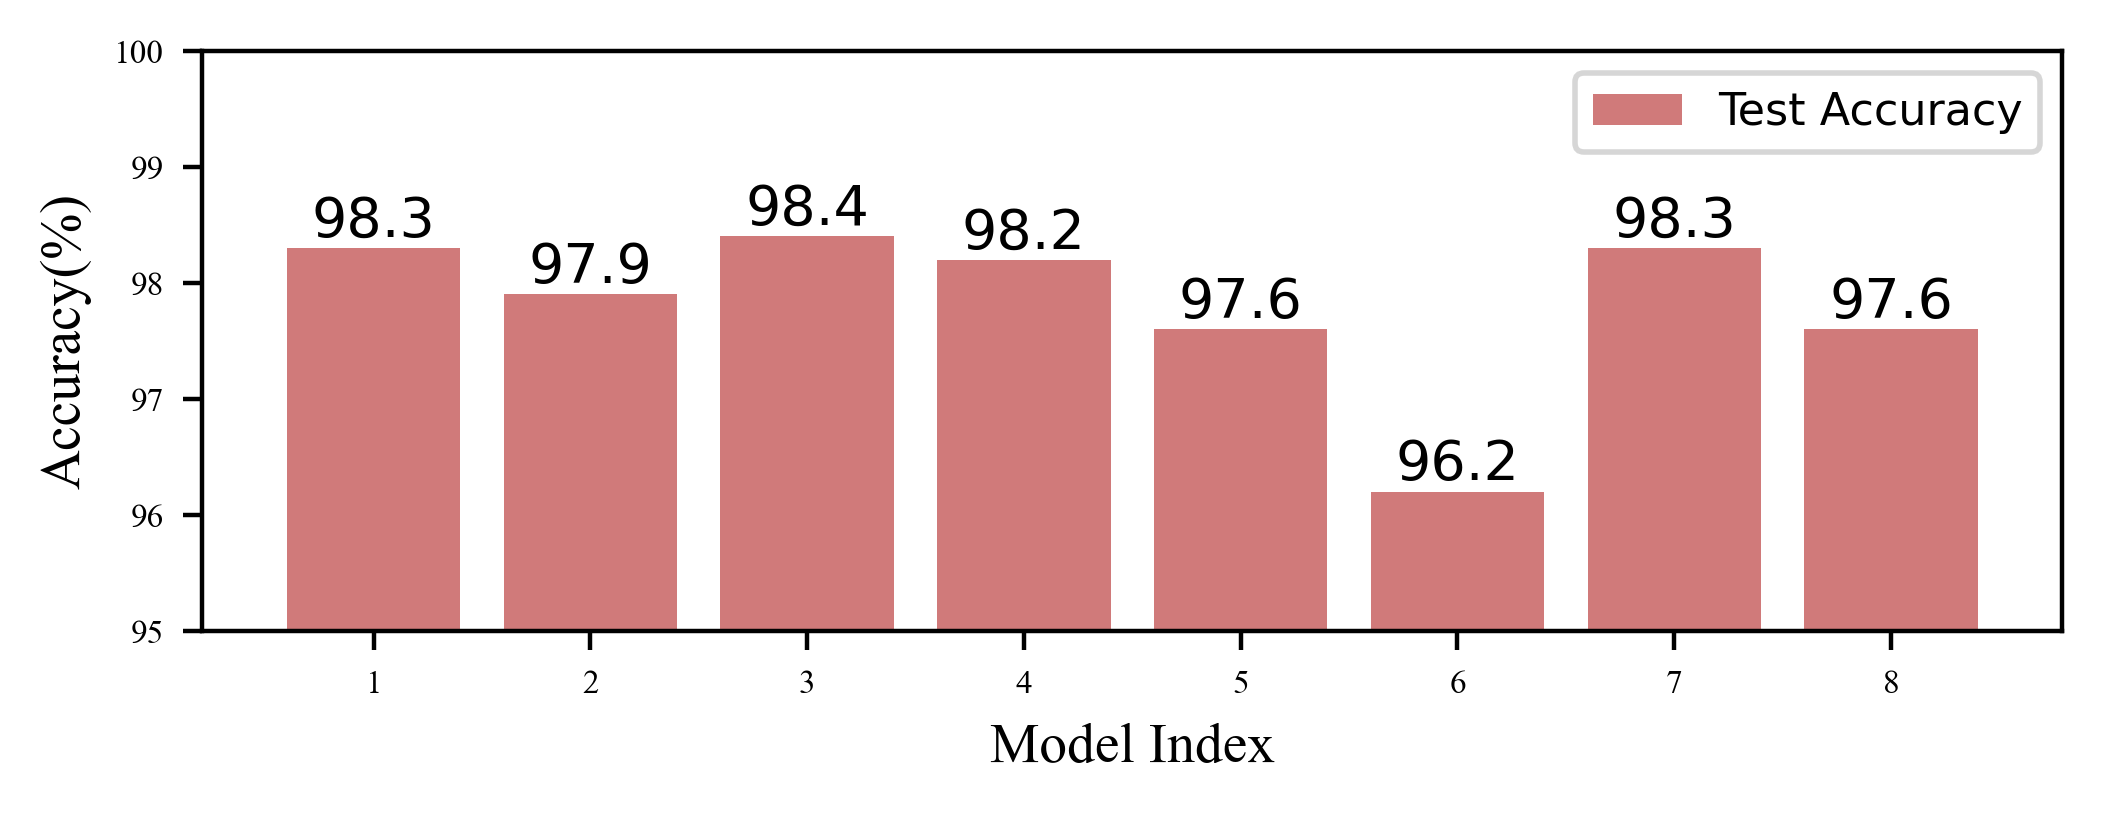

In [194]:
fig= plt.figure(figsize=(6,2),dpi=400)
fig.subplots_adjust(top=0.85, wspace=0.3)
ax1 = fig.add_subplot(111)
tr = plt.bar([1,2,3,4,5,6,7,8],acc_8,color='#B22222',alpha = 0.6,label='Test Accuracy')
for a, b in zip([1,2,3,4,5,6,7,8], acc_8):
    plt.text(a, b, '%.1f' % b, ha='center', va='bottom', fontsize=10)
# set font
x1_label = ax1.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax1.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
parameters = {'xtick.labelsize': 6,
          'ytick.labelsize': 6,
              'legend.fontsize':8}
plt.rcParams.update(parameters)
plt.xlabel('Model Index', fontsize=10,family='Times New Roman')
plt.ylabel('Accuracy(%)', fontsize=10,family='Times New Roman')
plt.ylim((95,100))

plt.legend(loc='best')
plt.savefig("acc_2.png",bbox_inches='tight',facecolor='white',transparent=True)
plt.show()

[55.8, 57.05, 59.5, 59.9, 58.9, 61.4, 69.8, 91.9, 89.9, 91.5, 91.1, 87.9, 92.3, 92.25, 91.8, 91.76, 87.8, 93.2, 93, 93, 93, 92.66, 93.1, 92.5, 93.04, 93.60785483148854, 93.59946661250913, 92.92352939781355, 94.25216280785867, 92.57197256631163, 93.16004290347972, 93.22586860674957, 93.73680375457815, 92.73776289090348, 93.13340386874302, 93.45131759169954, 93.2268896913487, 93.99764461592723, 92.08363445220394, 93.57138251579607, 93.61211566097951, 92.75954277724267, 93.07754867424465, 93.51094794419919, 93.55245867739923, 93.34792555174627, 92.88893687047553, 93.64704384864663, 94.67496955278098, 94.41206969851356, 92.89517380040624, 94.46884585464039, 93.19751182419469, 95.00493479653205, 94.47237111673944, 93.89166397710812, 94.00536083533505, 94.29430862049492, 93.47888256109695, 93.95929389342307, 93.46198534085401, 94.29886750517171, 94.36483193175103, 94.03282148733032, 94.27855617537193, 94.70473017396, 94.46312172134529, 93.67100817894041, 95.12338206752017, 94.82253926041315,

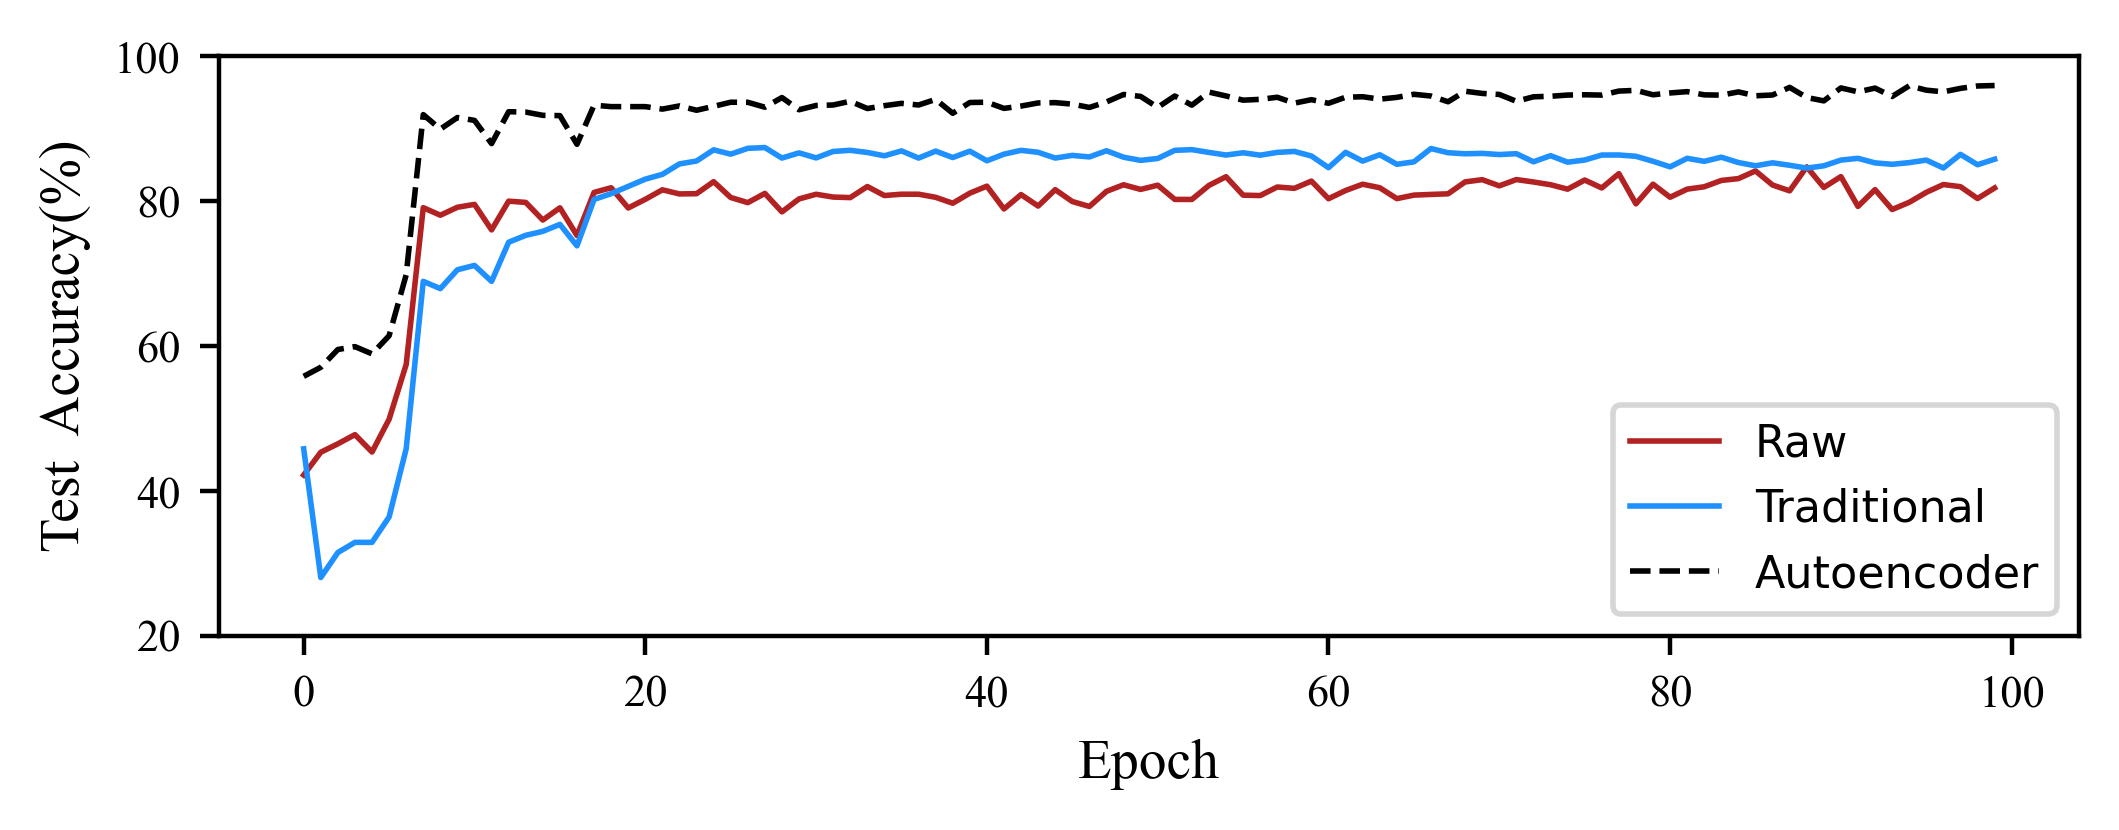

In [325]:
print(acc_2)
fig= plt.figure(figsize=(6,2),dpi=400)
fig.subplots_adjust(top=0.85, wspace=0.3)
ax1 = fig.add_subplot(111)
t1 = plt.plot(ac_1,color='#B22222',label='Raw',linewidth=1)
t2 = plt.plot(ac_3,color='#1E90FF',label='Traditional',linewidth=1)
t3 = plt.plot(acc_2,color='black',label='Autoencoder',linestyle='--',linewidth=1)

# set font
x1_label = ax1.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax1.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
parameters = {'xtick.labelsize': 8,
          'ytick.labelsize': 8,
              'legend.fontsize':8}
plt.rcParams.update(parameters)
plt.xlabel('Epoch', fontsize=10,family='Times New Roman')
plt.ylabel('Test  Accuracy(%)', fontsize=10,family='Times New Roman')
plt.ylim((20,100))
plt.legend(loc='best')
plt.savefig("imageaug.png",bbox_inches='tight',facecolor='white',transparent=True)
plt.show()

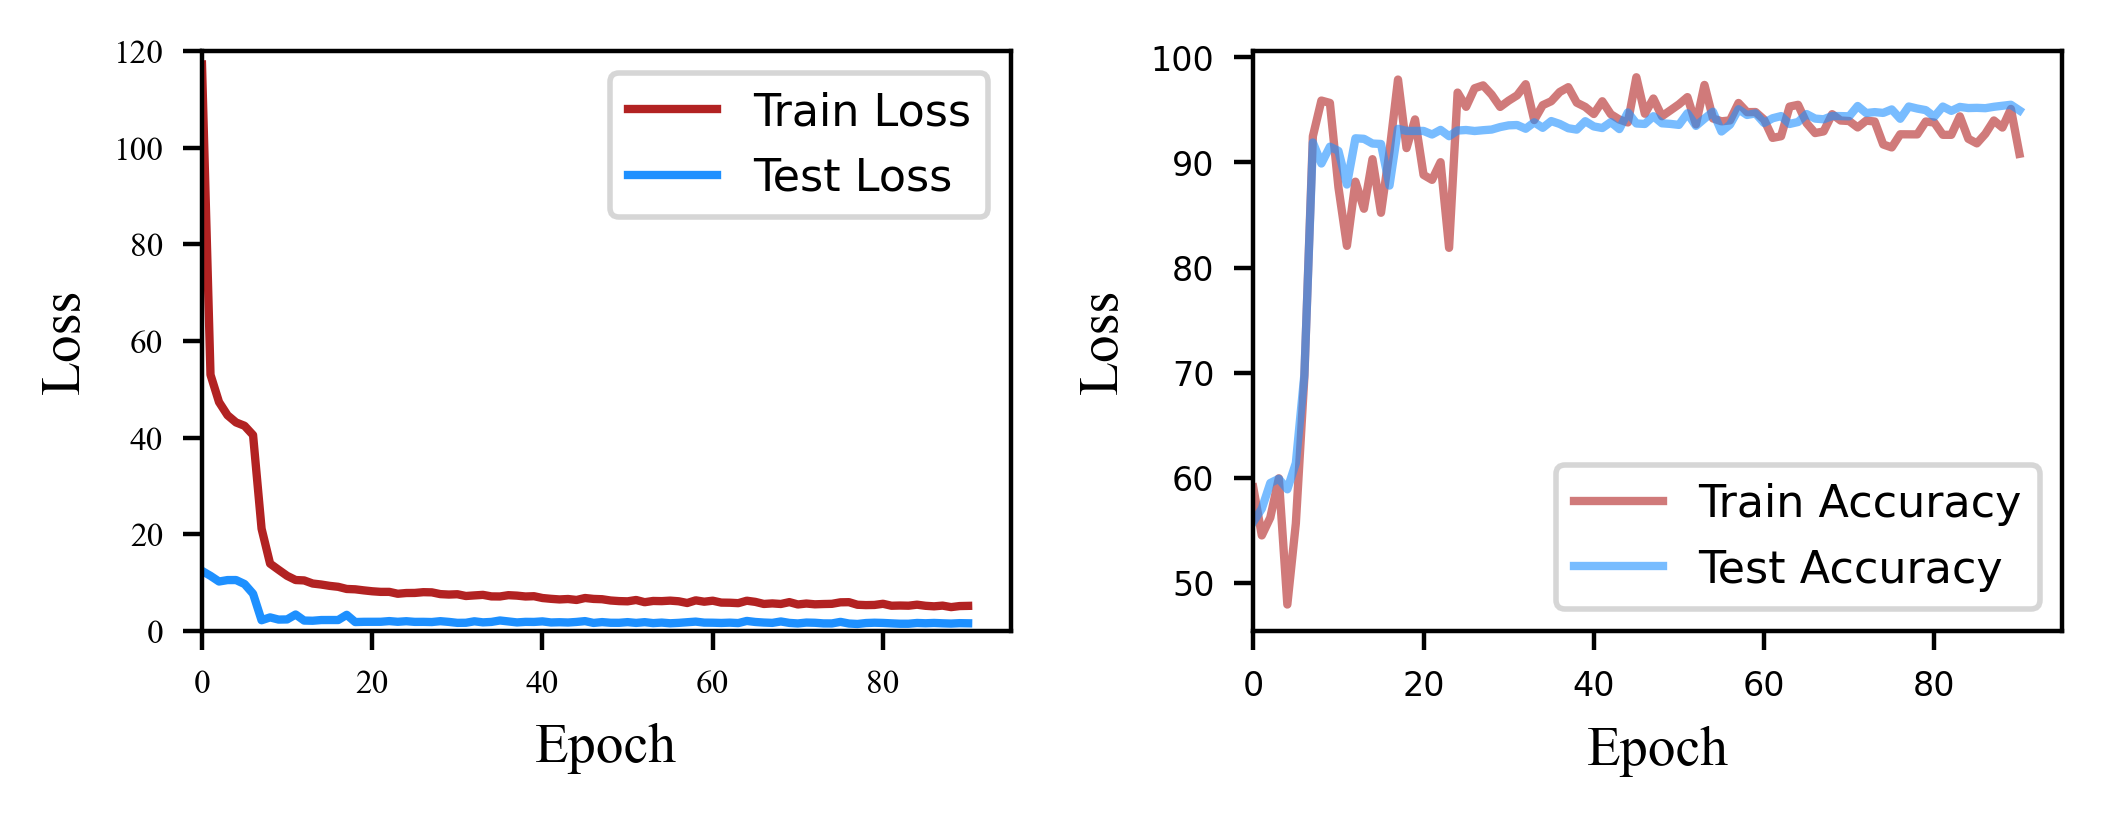

In [174]:
###wind power&wind speed ----  time
fig= plt.figure(figsize=(6,2),dpi=400)
fig.subplots_adjust(top=0.85, wspace=0.3)
ax1 = fig.add_subplot(121)
tr = plt.plot(train_loss2,color='#B22222',label='Train Loss')
te = plt.plot(test_loss2,color='#1E90FF',label='Test Loss')

# set font
x1_label = ax1.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax1.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
parameters = {'xtick.labelsize': 6,
          'ytick.labelsize': 6,
              'legend.fontsize':8}
plt.rcParams.update(parameters)
plt.xlabel('Epoch', fontsize=10,family='Times New Roman')
plt.ylabel('Loss', fontsize=10,family='Times New Roman')
plt.ylim((0,120))
plt.xlim((0,95))
plt.legend(loc='best')

ax2 = fig.add_subplot(122)
tr = plt.plot(acc_2,color='#B22222',alpha = 0.6,label='Train Accuracy')
te = plt.plot(acc_te,color='#1E90FF',alpha = 0.6,label='Test Accuracy')

# set font
x1_label = ax1.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax1.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
parameters = {'xtick.labelsize': 6,
          'ytick.labelsize': 6,
              'legend.fontsize':8}
plt.rcParams.update(parameters)
plt.xlabel('Epoch', fontsize=10,family='Times New Roman')
plt.ylabel('Loss', fontsize=10,family='Times New Roman')
# plt.ylim((0,120))
plt.xlim((0,95))
plt.legend(loc='best')

plt.savefig("loss_1.png",bbox_inches='tight',facecolor='white',transparent=True)
plt.show()